<a href="https://colab.research.google.com/github/LEEINSEO-0118/Seed_Weight_Predict/blob/main/seed_weight_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.1 MB/s eta 0:00:00
   ━━━━━

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import seaborn as sns
from tqdm import tqdm
import re

# Visualizatoins


## Make Scatter (2, 3)


In [3]:
def make_scatter(data, title = 'title'):
    # 플롯 설정
    fig, axes = plt.subplots(4, 3, figsize=(20, 20))  # 2행 3열의 서브플롯 생성
    axes = axes.flatten()  # 2D 배열을 1D로 변환

    # scatter 플롯 그리기
    variables = data.columns[:]  # 첫 번째 열 제외
    for i, var in enumerate(variables):
        sns.scatterplot(data=data, x='weight', y=var, ax=axes[i])  # ax 매개변수 추가
        axes[i].set_title(f'Correlation of weight - {var}')
        axes[i].set_xlabel('Weight')  # x축 레이블 수정
        axes[i].set_ylabel(var)  # y축 레이블 수정

    # 레이아웃 조정
    plt.tight_layout()
    plt.show()

# Information

Data
* 400 - (349 nonnull, 51 null)
* Seed Length (long, short)
* Seed weight
* Leaf Length (long, short)

# Preprocessing

* null 값 제거 -> 이용 가능한 데이터 : 349
* 종자 장 + 단 길이 생성
* 초엽 길이1 + 길이2 생성

In [336]:
# data load
path = f'/content/drive/MyDrive/졸업논문/data/numeric_data/data.xlsx'
data = pd.read_excel(path)
display(data.info())
data.replace(0, np.nan, inplace=True) # 0인 값을 null로 변환

data = data.drop(data.columns[:4], axis = 1) # index 등 제거
data = data.dropna() # null값 제거

print(f'Original Data Columns : {data.columns.values}')
print(f'Original Data Shape : {data.shape}')

# add seed size data
# data['seed_length_sum'] = data.seed_long + data.seed_short
# data['seed_div_1'] = abs(data.seed_long / data.seed_short)
# data['seed_div_2'] = abs(data.seed_short / data.seed_long)

# add leaf size data
data['leaf_length_sum'] = data.leaf_1 + data.leaf_2
data['leaf_area'] = data.leaf_1 * data.leaf_2
data['leaf_div_1'] = abs(data.leaf_1 / data.leaf_2)
data['leaf_div_2'] = abs(data.leaf_2 / data.leaf_1)

display(data.head())
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  400 non-null    int64  
 1   tray_num    400 non-null    int64  
 2   KNU         400 non-null    int64  
 3   name        400 non-null    object 
 4   weight      400 non-null    float64
 5   seed_long   400 non-null    float64
 6   seed_short  400 non-null    float64
 7   leaf_1      400 non-null    float64
 8   leaf_2      400 non-null    float64
dtypes: float64(5), int64(3), object(1)
memory usage: 28.2+ KB


None

Original Data Columns : ['weight' 'seed_long' 'seed_short' 'leaf_1' 'leaf_2']
Original Data Shape : (349, 5)


,weight,seed_long,seed_short,leaf_1,leaf_2,leaf_length_sum,leaf_area,leaf_div_1,leaf_div_2
0,0.17,7.976471,7.341176,5.0,4.3,9.3,21.50,1.162791,0.860000
1,0.19,7.844192,7.419240,4.0,3.4,7.4,13.60,1.176471,0.850000
2,0.16,8.841370,7.052203,5.5,4.4,9.9,24.20,1.250000,0.800000
4,0.21,8.058351,7.868689,6.5,5.9,12.4,38.35,1.101695,0.907692
5,0.19,8.435368,8.185801,6.0,4.6,10.6,27.60,1.304348,0.766667


<class 'pandas.core.frame.DataFrame'>
Index: 349 entries, 0 to 399
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   weight           349 non-null    float64
 1   seed_long        349 non-null    float64
 2   seed_short       349 non-null    float64
 3   leaf_1           349 non-null    float64
 4   leaf_2           349 non-null    float64
 5   leaf_length_sum  349 non-null    float64
 6   leaf_area        349 non-null    float64
 7   leaf_div_1       349 non-null    float64
 8   leaf_div_2       349 non-null    float64
dtypes: float64(9)
memory usage: 27.3 KB


None

# EDA

Non null data count = 349

In [285]:
# 데이터들의 상관관계 파악
data_num = data.copy()
display(data_num.corr())
print(data_num.isnull().sum())

,weight,seed_long,seed_short,leaf_1,leaf_2,leaf_length_sum,leaf_area,leaf_div_1,leaf_div_2
weight,1.000000,0.895460,0.898967,0.226299,0.551411,0.414213,0.461696,-0.477684,0.475763
seed_long,0.895460,1.000000,0.893220,0.149306,0.472183,0.330226,0.375631,-0.470349,0.455112
seed_short,0.898967,0.893220,1.000000,0.203024,0.509371,0.379319,0.415862,-0.456619,0.451924
leaf_1,0.226299,0.149306,0.203024,1.000000,0.728638,0.933016,0.890807,0.242277,-0.289992
leaf_2,0.551411,0.472183,0.509371,0.728638,1.000000,0.926282,0.946257,-0.467639,0.416407
leaf_length_sum,0.414213,0.330226,0.379319,0.933016,0.926282,1.000000,0.987271,-0.112390,0.059220
leaf_area,0.461696,0.375631,0.415862,0.890807,0.946257,0.987271,1.000000,-0.189683,0.137583
leaf_div_1,-0.477684,-0.470349,-0.456619,0.242277,-0.467639,-0.112390,-0.189683,1.000000,-0.971315
leaf_div_2,0.475763,0.455112,0.451924,-0.289992,0.416407,0.059220,0.137583,-0.971315,1.000000


weight             0
seed_long          0
seed_short         0
leaf_1             0
leaf_2             0
leaf_length_sum    0
leaf_area          0
leaf_div_1         0
leaf_div_2         0
dtype: int64


## Distribution

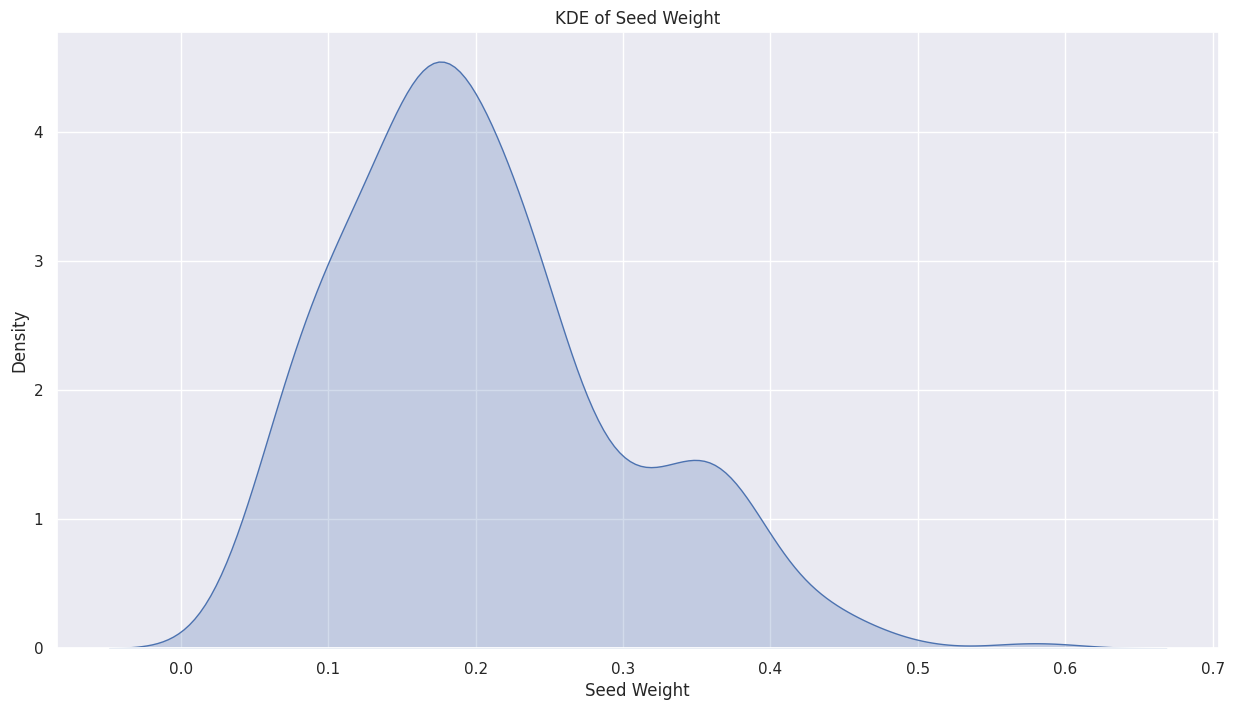

In [286]:
# KDE 플롯 그리기
sns.kdeplot(data_num.weight, fill=True)
plt.title('KDE of Seed Weight')
plt.xlabel('Seed Weight')
plt.ylabel('Density')
plt.show()

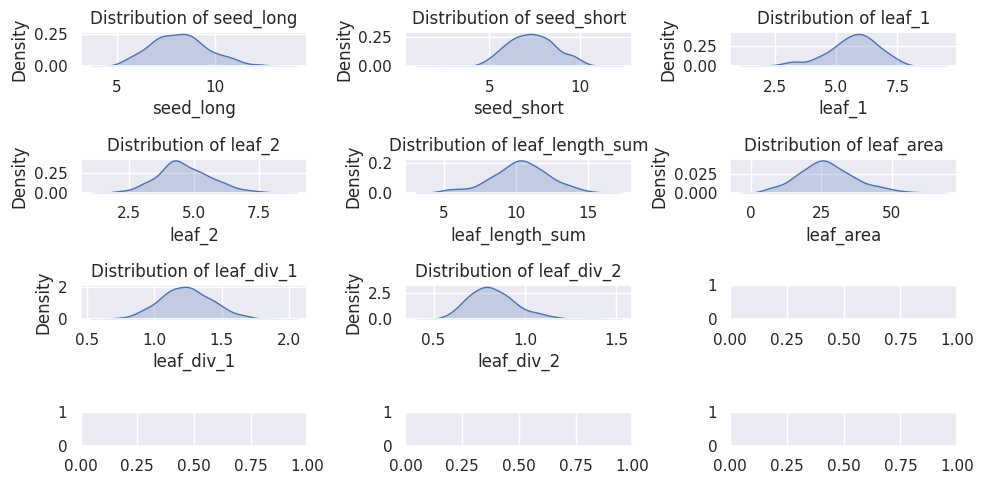

In [287]:
# 플롯 설정
fig, axes = plt.subplots(4, 3, figsize=(10, 5))  # 2행 3열의 서브플롯 생성
axes = axes.flatten()  # 2D 배열을 1D로 변환

# KDE 플롯 그리기
variables = data_num.columns[1:]
for i, var in enumerate(variables):
    if var in data.select_dtypes(include=['float64', 'int']).columns:  # 연속형 변수만 선택
        sns.kdeplot(data[var], ax=axes[i], fill=True)
        axes[i].set_title(f'Distribution of {var}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Density')

# 레이아웃 조정
plt.tight_layout()
plt.show()

## Target 로그변환시 분포

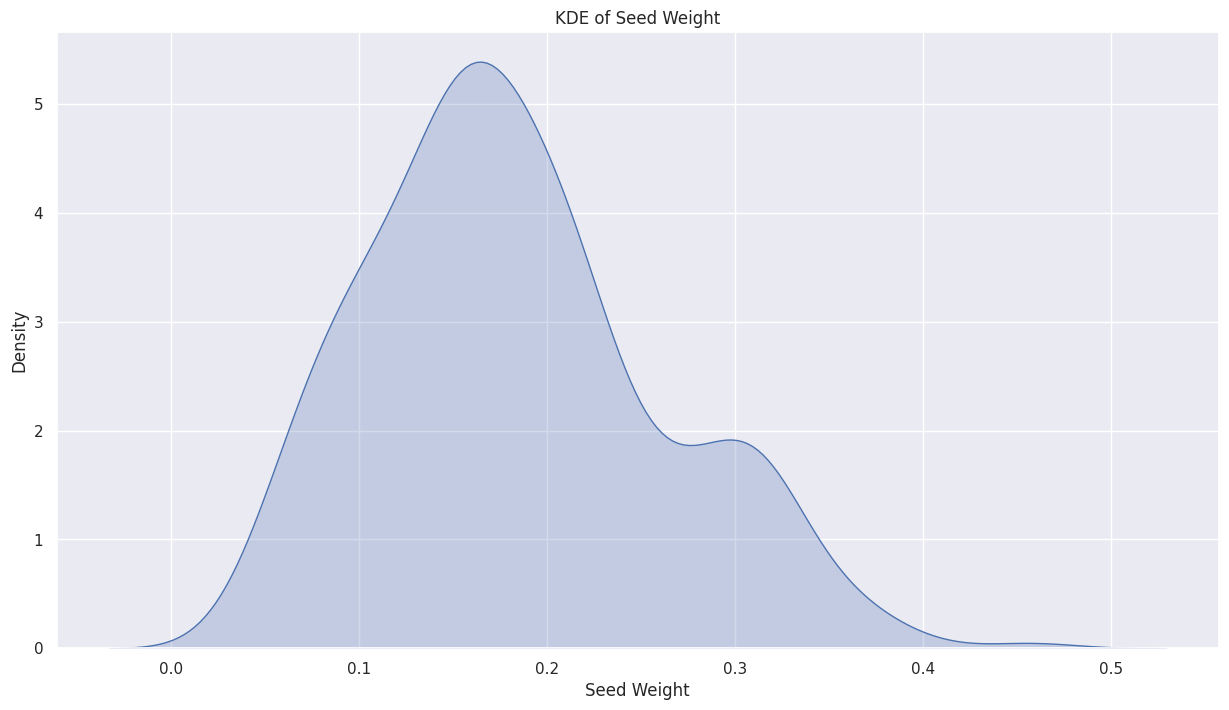

In [288]:
# KDE 플롯 그리기
weight_log = np.log1p(data_num.weight)
sns.kdeplot(weight_log, fill=True)
plt.title('KDE of Seed Weight')
plt.xlabel('Seed Weight')
plt.ylabel('Density')
plt.show()

## correlation heatmap

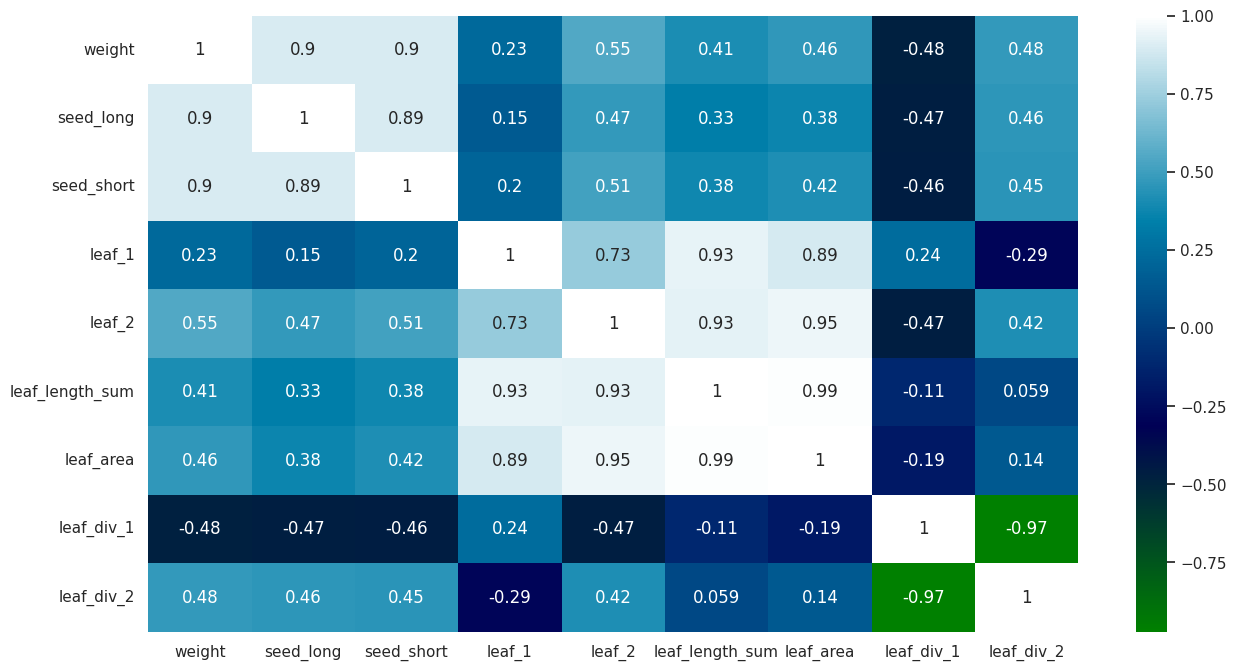

In [289]:
sns.heatmap(data_num.corr(), annot = True, cmap = 'ocean')
sns.set_theme(rc={'figure.figsize':(8,8)})

종자 무게와 잎 크기 간의 상관관계가 생각보다 작았음 -> 0.41

## 무게와 - 잎 가로, 잎 세로, 잎 가로세로 합, 잎 넓이의 산점도를 통한 데이터 분포 확인

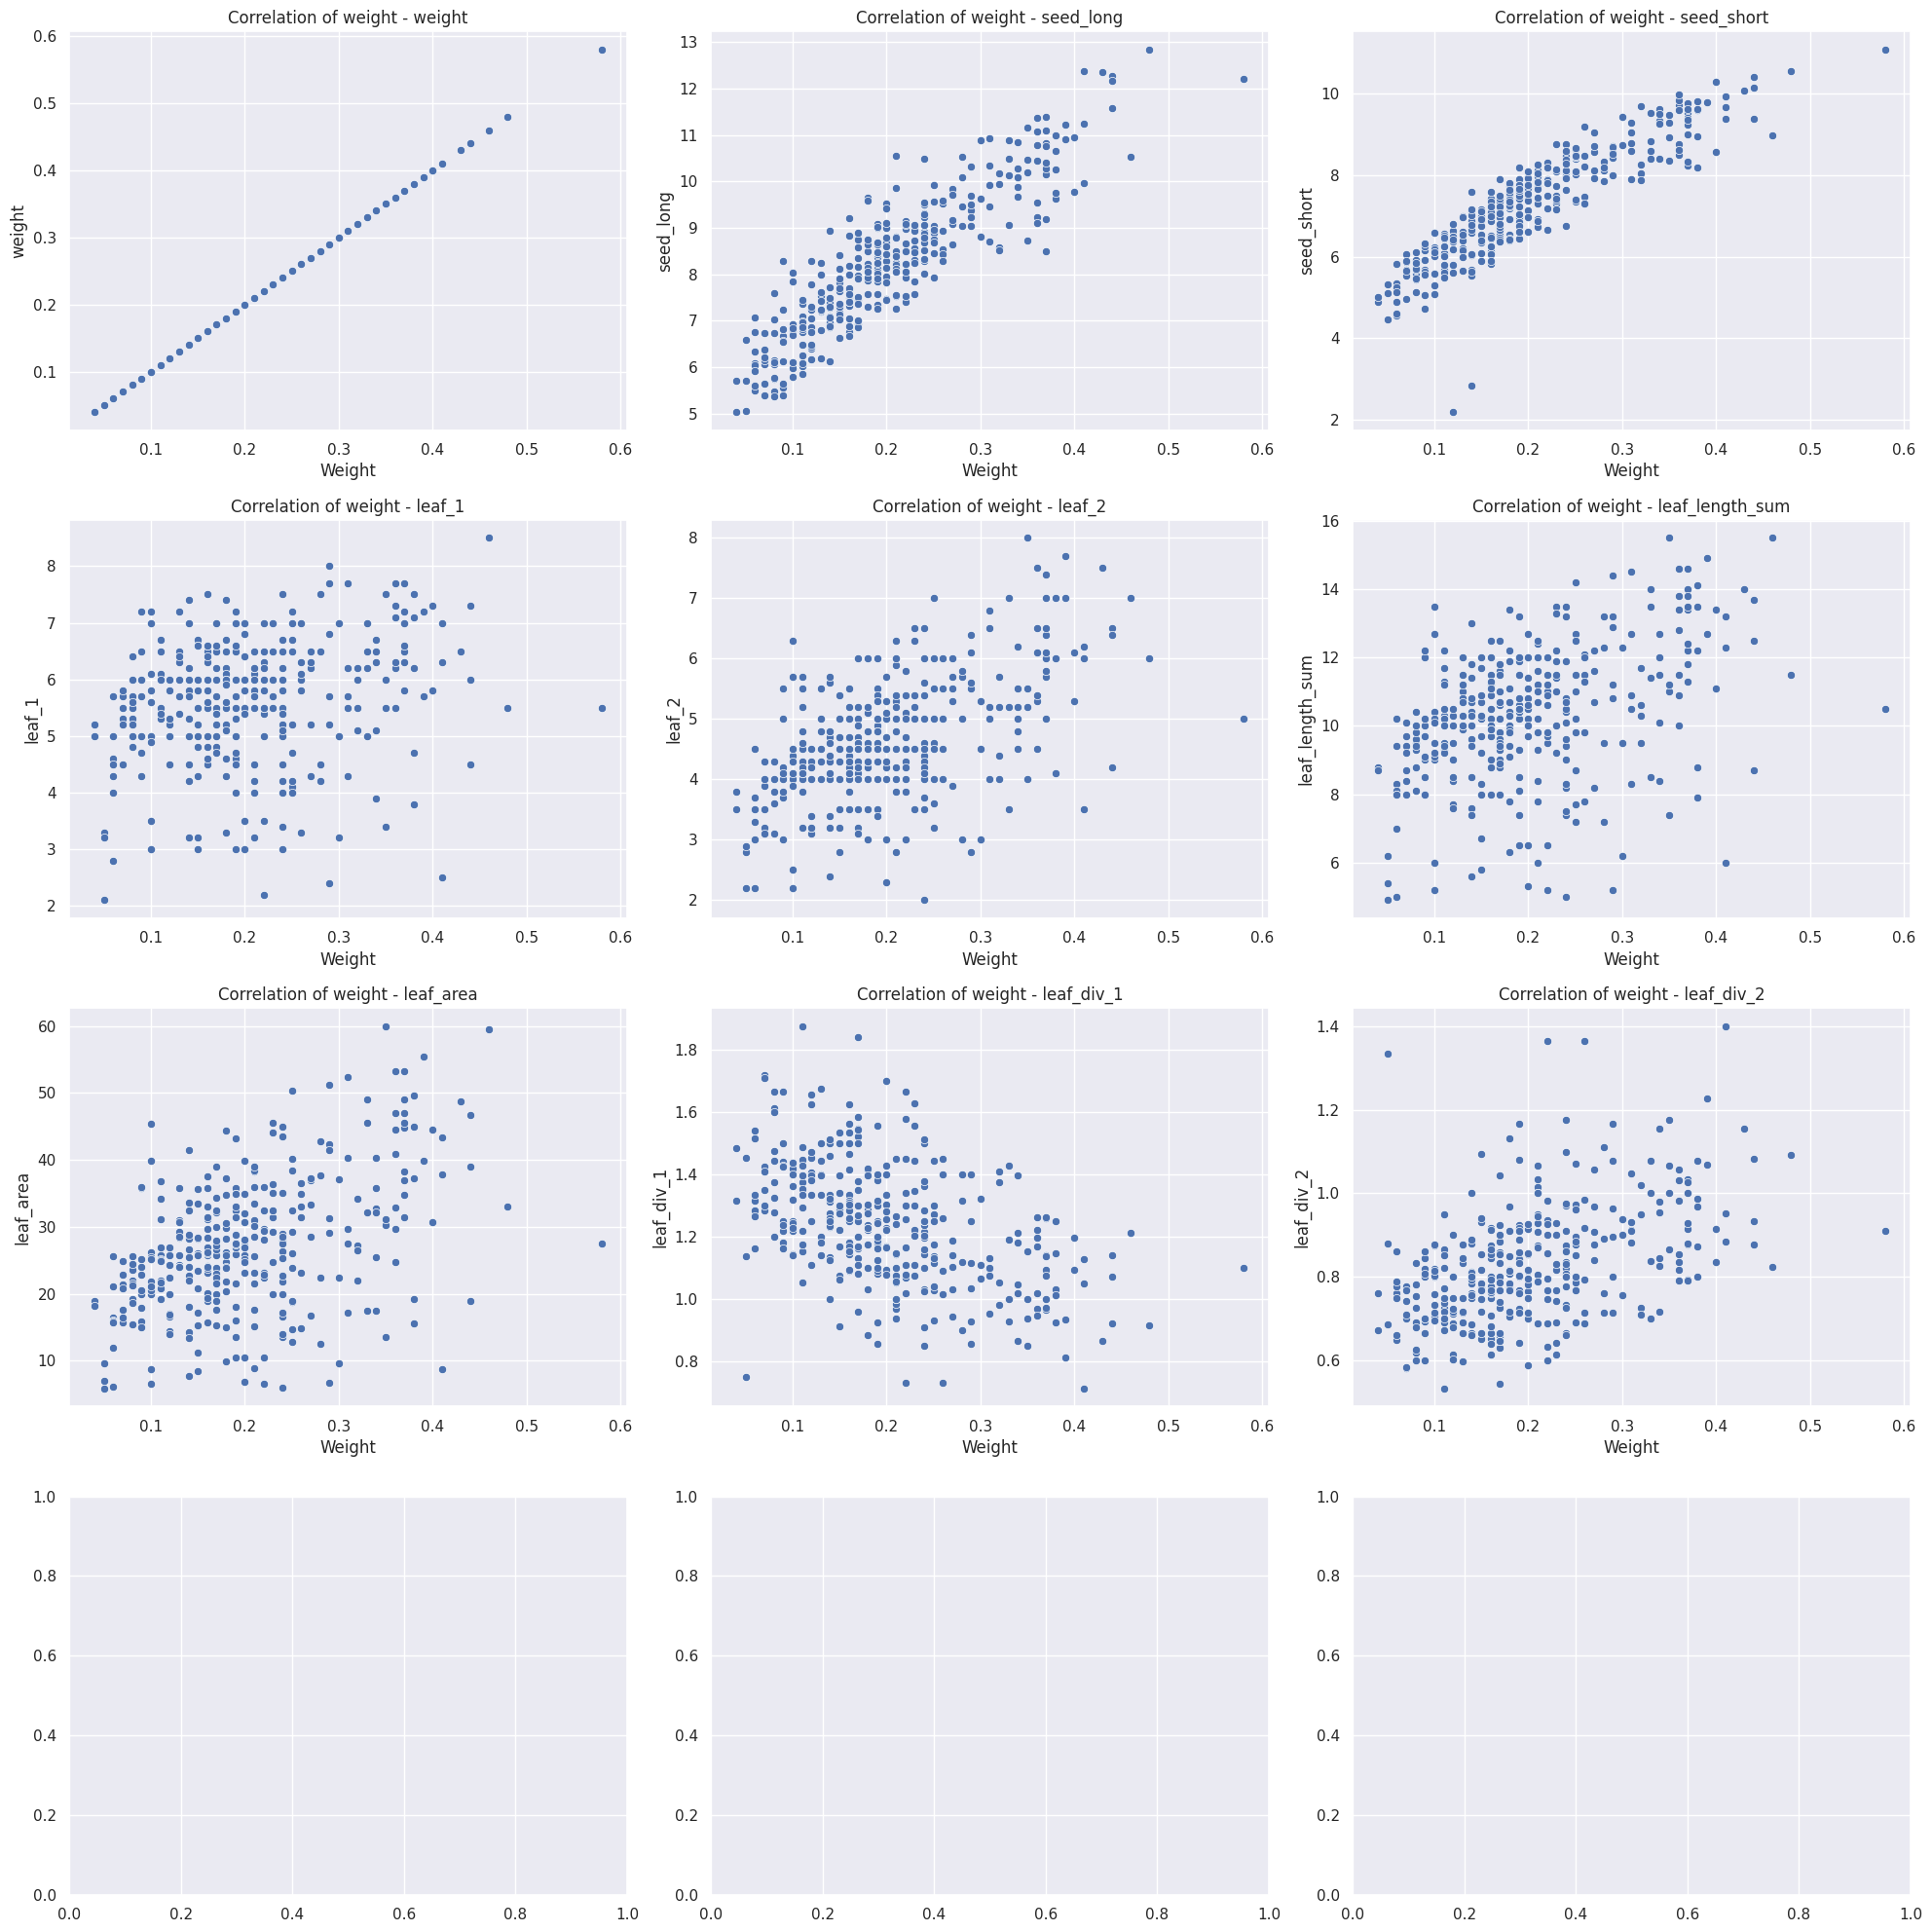

In [290]:
make_scatter(data_num, 'Weight-Feature Correlation')

- 팟을 관찰 했을 때 다른 잎에 가려지는 등 환경의 요인으로 잎이 정상적으로 생장하지 못한 것들이 있었다.
- 그래서 잎의 크기 중 이상치라고 판단되는 것들을 제거 하기로 결정


* leaf_length_sum을 기준으로 하여 threshold를 설정해 해당 값 보다 크기가 작은 데이터를 삭제하면 상관계수가 상승할 것으로 보임  
* 주변 환경으로 인해서 생육이 덜 되어, 데이터 분석에 방해가 되는 데이터를 제거하는 행위

## Data preprocessing

Data num : 349
Data num : 269


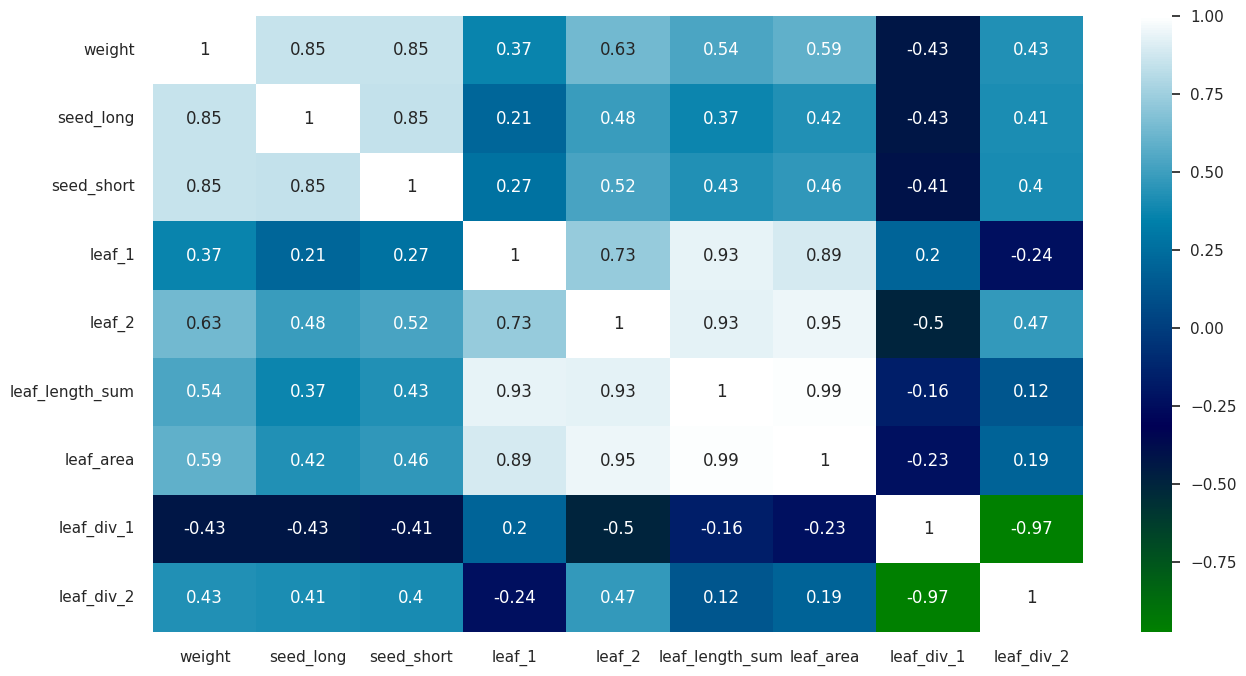

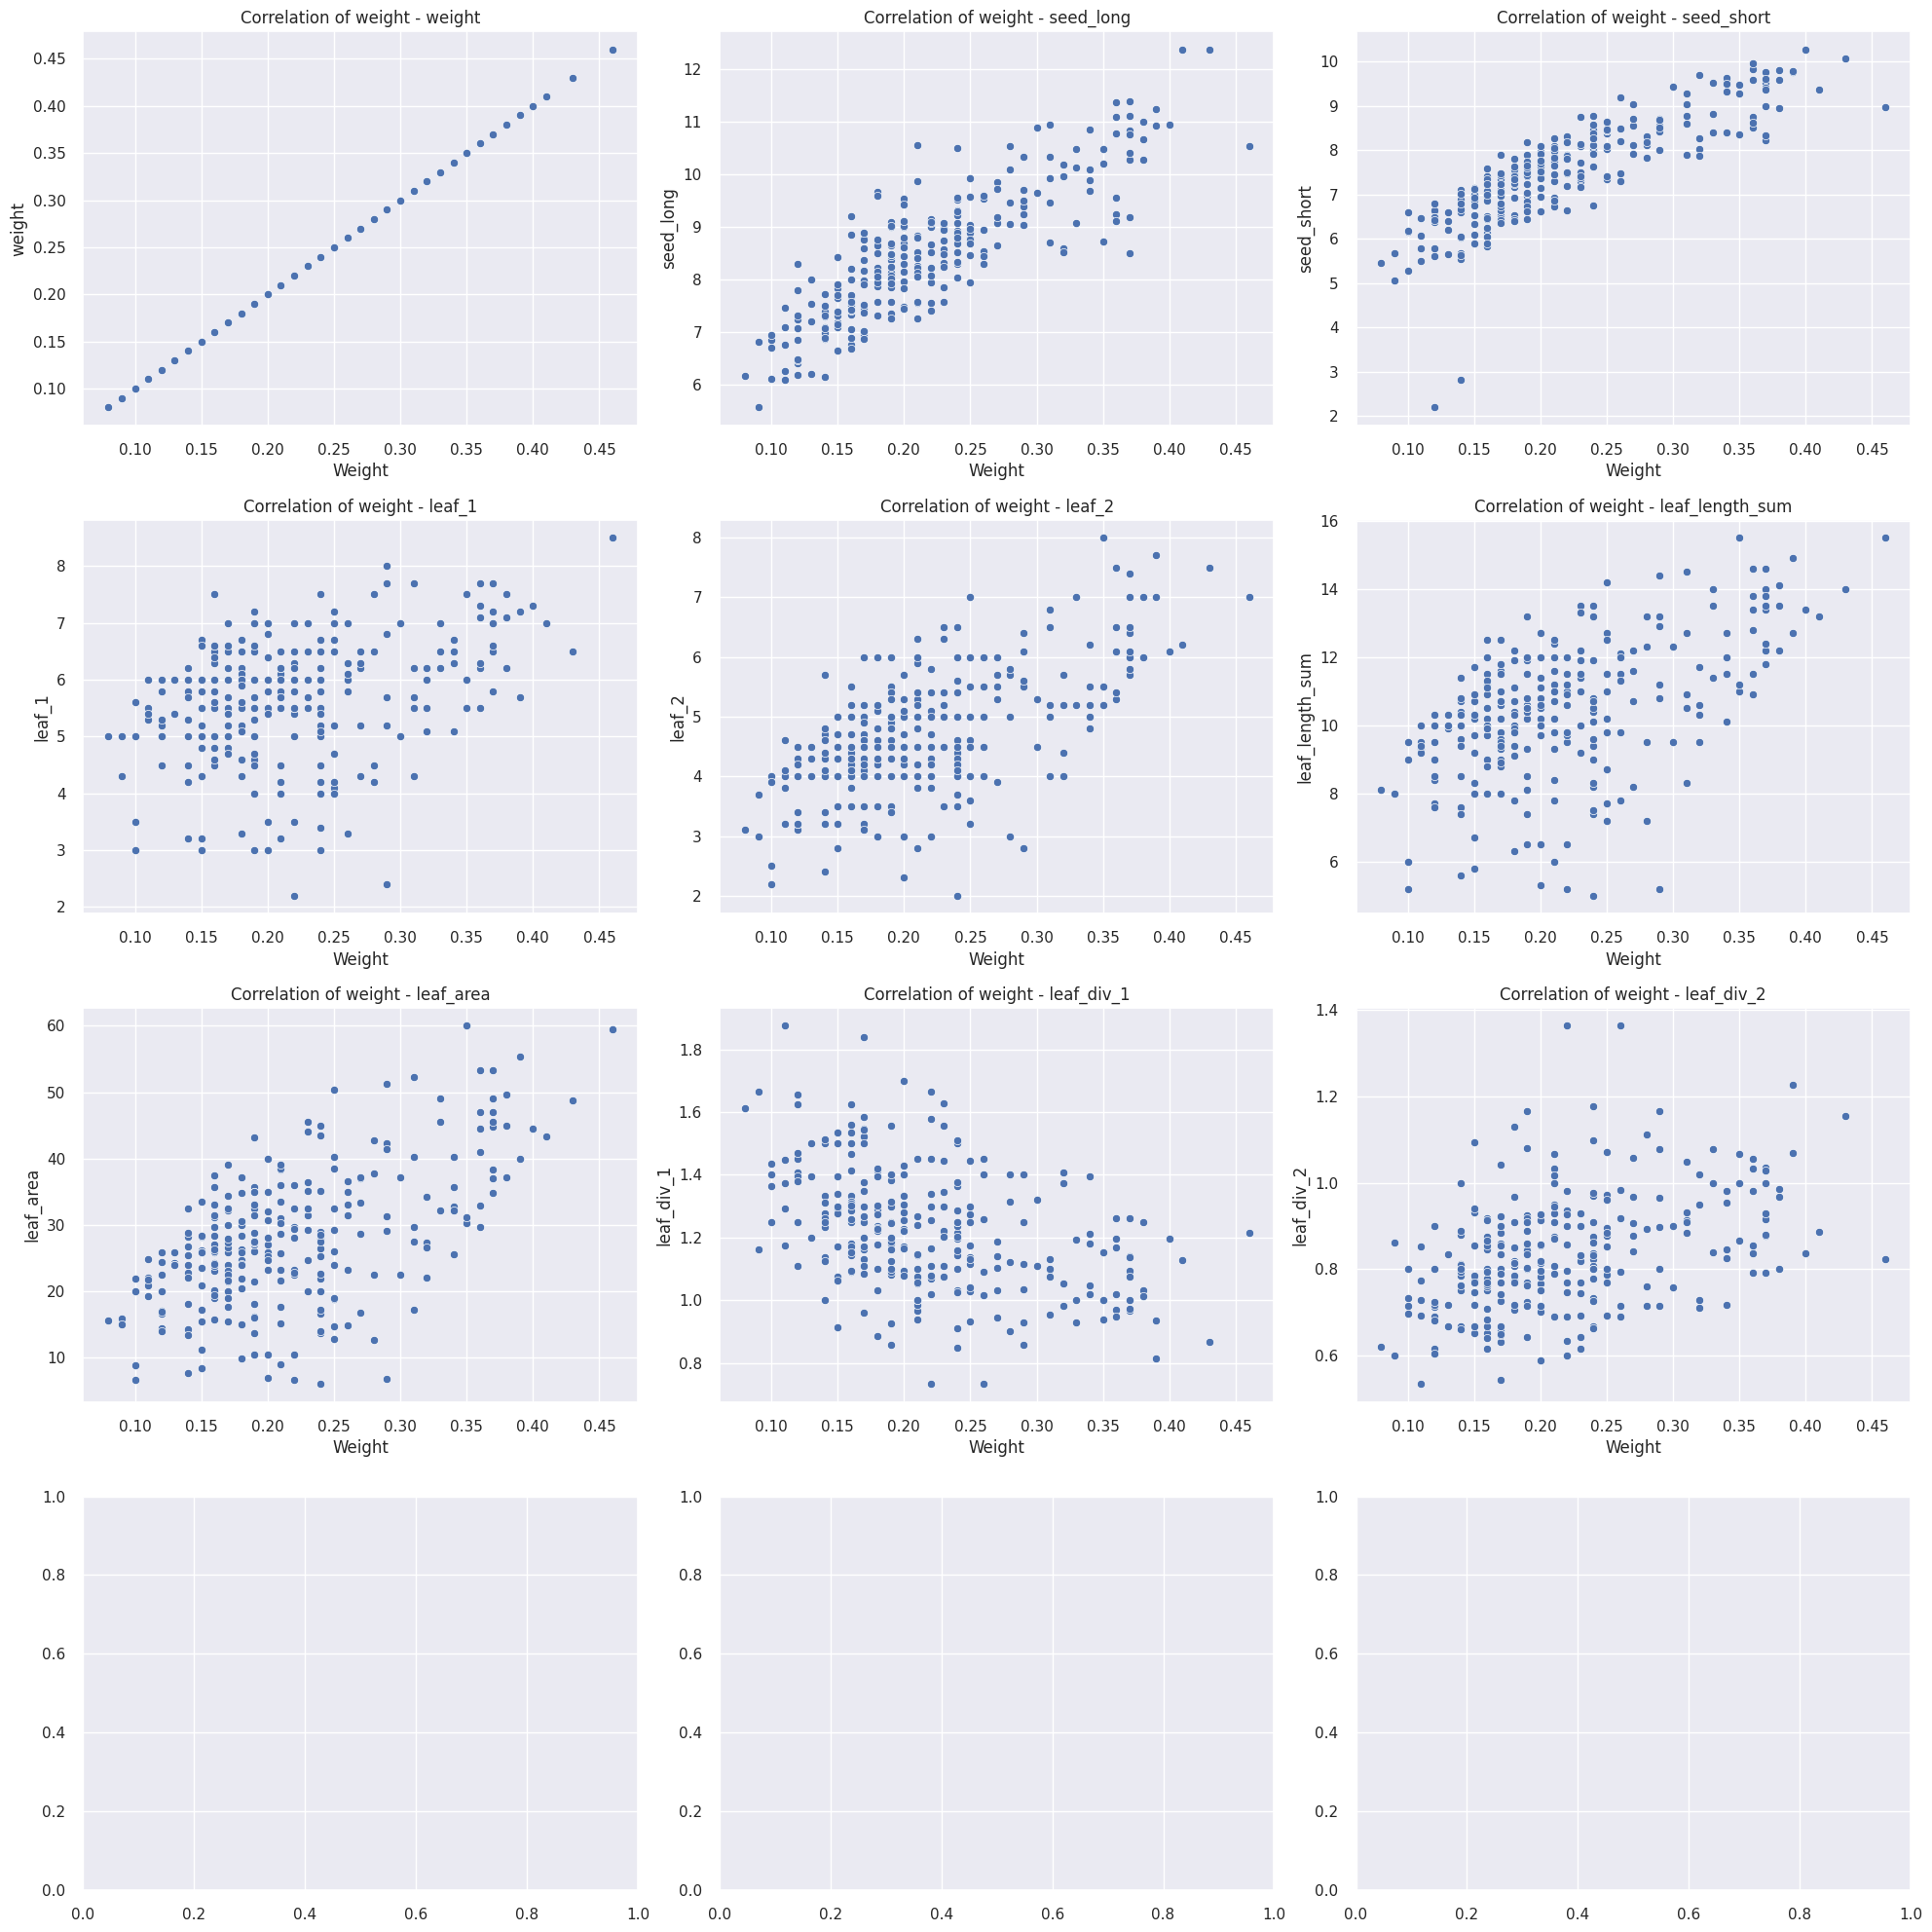

In [391]:
# 확정된 전처리
# data_filtered = data_num[(data_num.leaf_length_sum >= 8)]     # 잎 길이 합이 8이상인 것 남김, null도 살림
# data_filtered = data_filtered[data_filtered.weight <= 0.5] # 잎 넓이를 보았을 때, 무게 0.5 이상인 것들의 잎 넓이가 이상치로 판단됨
# data_filtered = data_filtered[data_filtered.weight <= 0.35] # 0.35이하의 값만 사용하게 되면, 상관관계 수치는 떨어지지만, SMOTER를 사용하여 모델을 적용한 후의 성능은 보다 상승함

# 확인 중인 전처리
# data_filtered = data_filtered[data_filtered.leaf_div_2 <= 1.25] # leaf_div_2 기준으로 해당 값이 1.25 이상인 값을 제거
# data_filtered = data_filtered[~((data_filtered.weight >= 0.4) & (data_filtered.leaf_div_2 < 0.9))]


# data_filtered = data_filtered[~((data_filtered.weight >= 0.3) & (data_filtered.leaf_area < 20))]
# data_filtered = data_filtered[~((data_filtered.weight >= 0.4) & (data_filtered.leaf_area < 40))]


##### RANSAC
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_absolute_error

data_filtered = data_num.copy()
# display(data_filtered)
print(f'Data num : {len(data_filtered)}')
answer = data_filtered.pop('weight')

ransac = RANSACRegressor(
                        random_state=2024,       # 랜덤 시드
                        min_samples=2,         # 최소 샘플 비율 (50%)
                        residual_threshold=0.1,    # 잔차 임계값 설정 ------> 0.08(13%) 기록 해야 함, 0.1(11%)
                        max_trials=100,          # 최대 시도 횟수
                        stop_n_inliers=300,       # 최소 50개의 inlier로 모델 종료
                        stop_score=0.99,         # 모델 정확도가 99%에 도달하면 종료
                        loss='absolute_error',
                    )
ransac.fit(data_filtered, answer)

# 이상치 마스크
inlier_mask = ransac.inlier_mask_

# 이상치 제거 후 Train 데이터
x_inliers = data_filtered[inlier_mask]
y_inliers = answer[inlier_mask]

data_filtered = pd.concat([y_inliers, x_inliers], axis=1)
# data_filtered
print(f'Data num : {len(data_filtered)}')

sns.heatmap(data_filtered.corr(), annot = True, cmap = 'ocean')
plt.show()
make_scatter(data_filtered)

## Feature Selection

train-valid shape :  (198, 6) (50, 6) (198,) (50,)


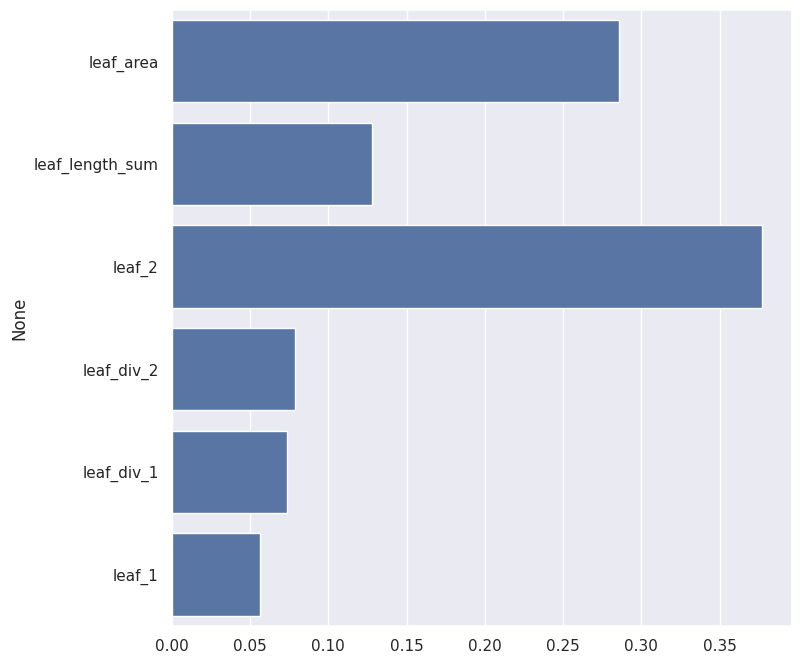

In [292]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

cols = set(data_filtered.columns[1:])
seed_data = set(['seed_long', 'seed_short', 'seed_length_sum'])
cols = list(cols - seed_data)
x_train, x_test, y_train, y_test = train_test_split(data_filtered[cols], data_filtered.weight, test_size = 0.2, random_state = 2024)
print('train-valid shape : ', x_train.shape, x_test.shape, y_train.shape, y_test.shape)

model = RandomForestRegressor(random_state = 2024)
model.fit(x_train, y_train)
feature_importances = model.feature_importances_

sns.barplot(x = feature_importances, y = x_train.columns)
plt.show()

,weight,seed_long,seed_short,leaf_2,leaf_length_sum,leaf_area,leaf_div_1,leaf_div_2
0,0.17,7.976471,7.341176,4.3,9.3,21.50,1.162791,0.860000
2,0.16,8.841370,7.052203,4.4,9.9,24.20,1.250000,0.800000
4,0.21,8.058351,7.868689,5.9,12.4,38.35,1.101695,0.907692
5,0.19,8.435368,8.185801,4.6,10.6,27.60,1.304348,0.766667
6,0.14,7.390000,5.540000,2.4,5.6,7.68,1.333333,0.750000


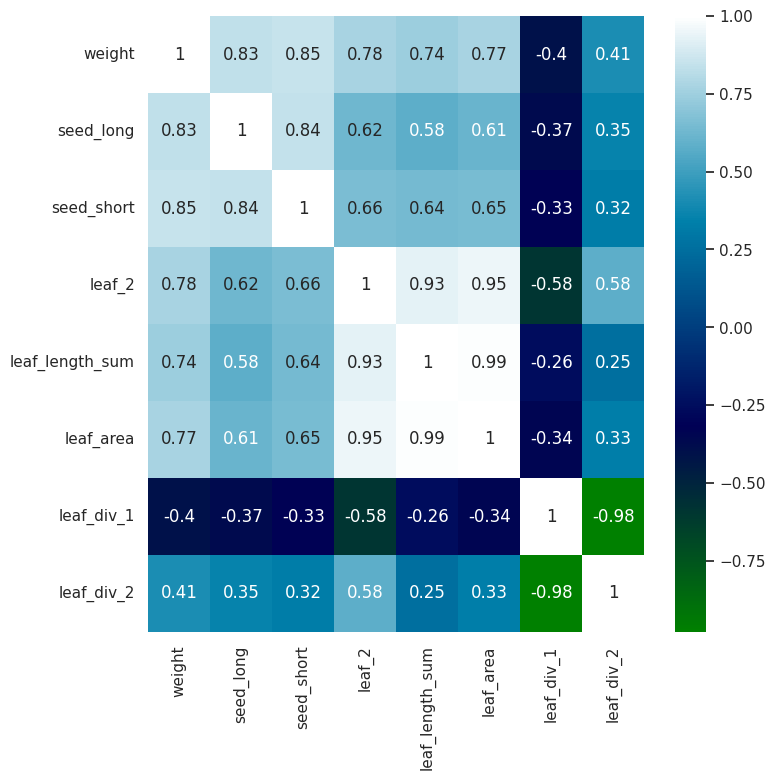

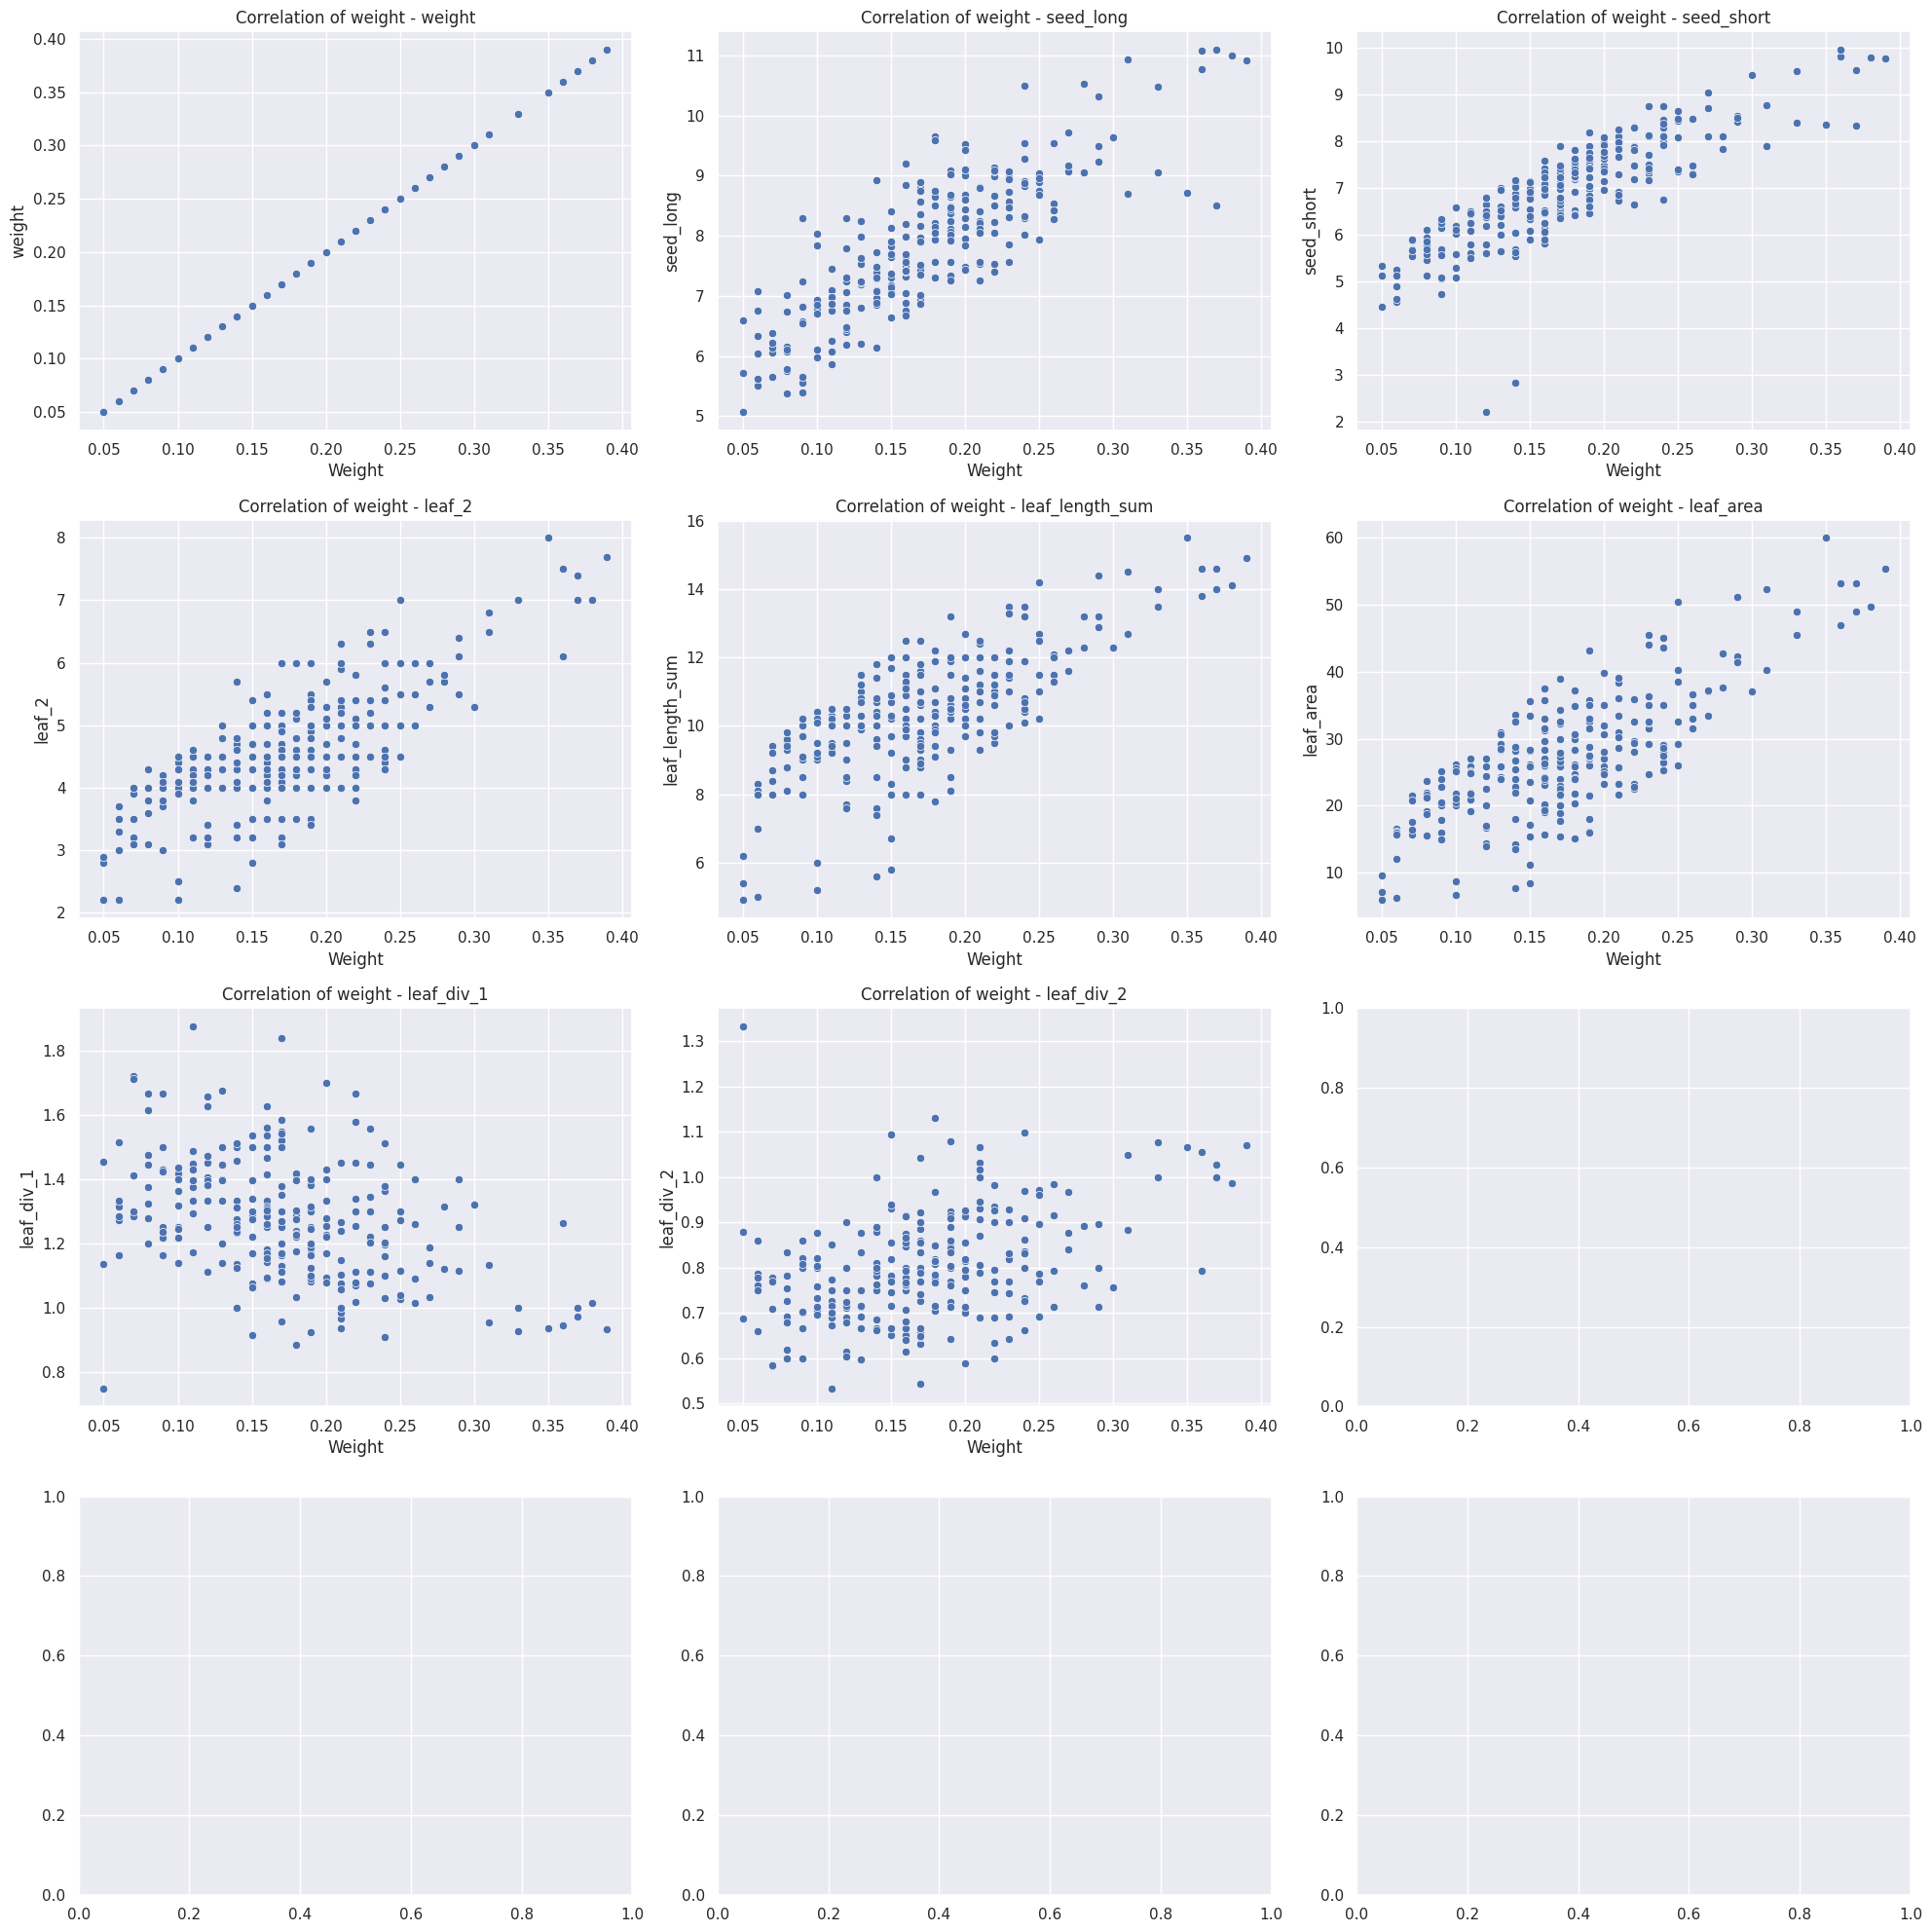

In [293]:
# Feature importance 기반 상위 4개의 column만 선택
out_cols = ['leaf_1']
data_filtered = data_filtered.drop(out_cols, axis = 1)
display(data_filtered.head())

sns.heatmap(data_filtered.corr(), annot = True, cmap = 'ocean')
plt.show()
make_scatter(data_filtered)

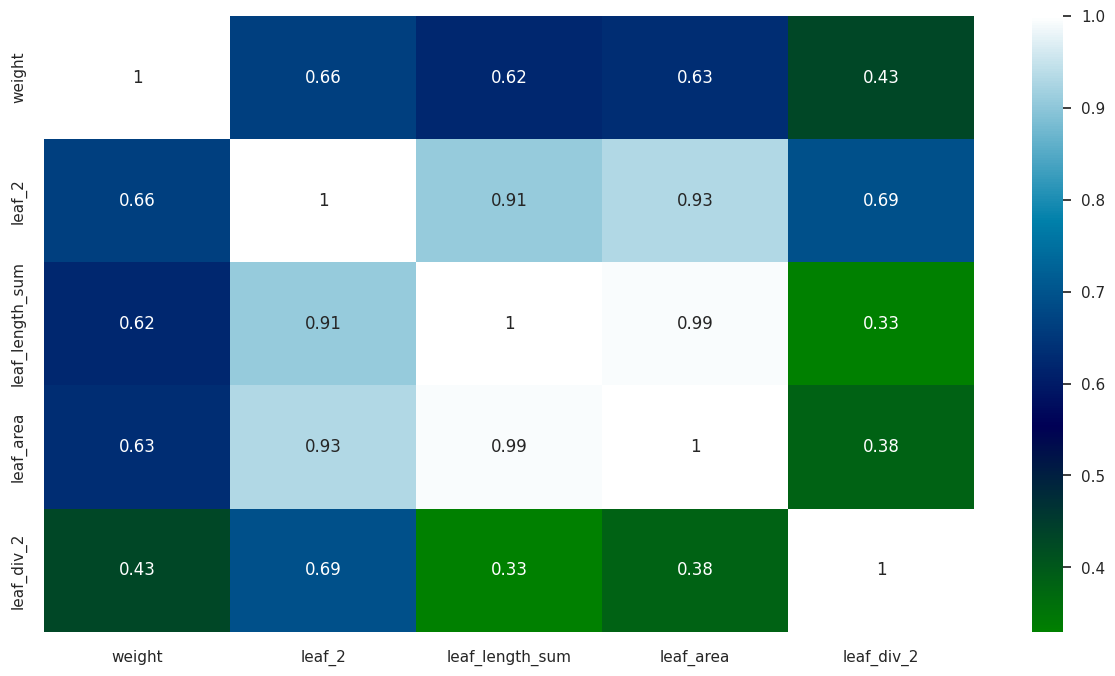

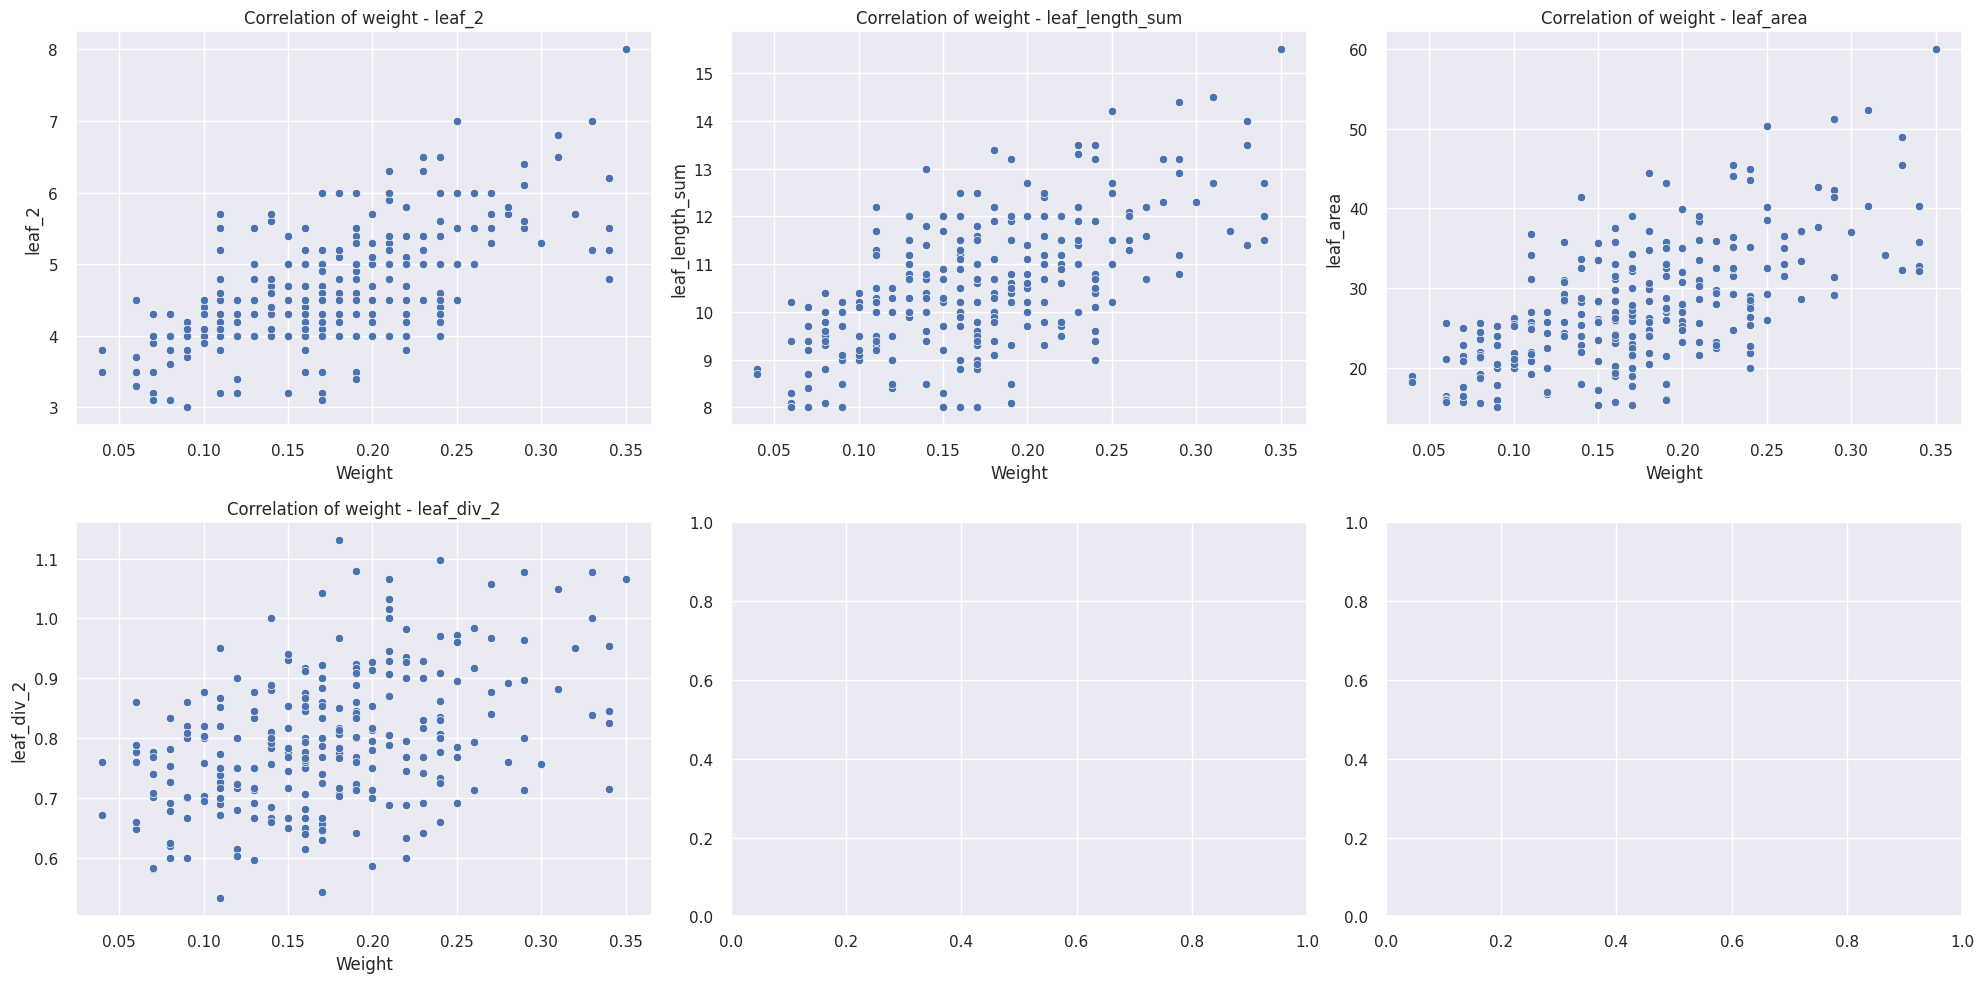

In [ ]:
# #### 상관관계가 약한 피쳐 제거
# data_filtered = data_filtered.drop(['leaf_1'], axis = 1)

# #### 다중공선성 제거
# data_filtered = data_filtered.drop(['leaf_div_1'], axis = 1)
# # data_filtered = data_filtered.drop(['leaf_area'], axis = 1)
# # data_filtered = data_filtered.drop(['leaf_div_2'], axis = 1)


# sns.heatmap(data_filtered.corr(), annot = True, cmap = 'ocean')
# plt.show()
# make_scatter(data_filtered)

# Modeling

## Origin data - Test data Compare Plot

In [99]:
def origin_test_scatter(origin, pred):
    val = pd.DataFrame({'val_answer': origin, 'pred' : pred})
    sns.set_theme(rc={'figure.figsize':(15,8)})
    sns.scatterplot(data = val, x = 'val_answer', y = 'pred', color='blue', alpha=0.6)
    sns.lineplot(x=[val['val_answer'].min(), val['val_answer'].max()],
                y=[val['val_answer'].min(), val['val_answer'].max()],
                color='red', linestyle='--')
    plt.xlabel('Validation Origin Data')
    plt.ylabel('Predicted Weight')
    plt.title("Weight Predict")
    plt.show()

## SMOTER (SMOTE for Regression)

In [31]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def smoter(train, N=10, k_neighbors=5):
    """
    SMOTER: 회귀용 SMOTE 구현
    N: 생성할 새로운 샘플 수
    k_neighbors: 가까운 이웃을 찾을 수
    """
    # 데이터 분리
    y_train = train.pop('weight')
    X_train = train.values

    # 훈련 데이터의 샘플 수
    n_samples, n_features = X_train.shape

    # 랜덤 시드를 설정 (랜덤 상태를 지정)
    np.random.seed(2024)

    # 가까운 이웃을 찾기 위해 K-Nearest Neighbors 사용
    nn = NearestNeighbors(n_neighbors=k_neighbors)
    nn.fit(X_train)

    # 새로운 샘플과 타겟 변수 리스트 초기화
    synthetic_samples = []
    synthetic_labels = []

    for i in range(n_samples):
        # 가까운 이웃 찾기 (자기 자신 제외)
        neighbors = nn.kneighbors([X_train[i]], n_neighbors=k_neighbors+1)[1][0][1:]

        # N개의 새로운 샘플 생성
        for _ in range(N):
            neighbor_idx = np.random.choice(neighbors)  # 무작위로 이웃 선택
            diff = X_train[neighbor_idx] - X_train[i]  # 차이 계산
            gap = np.random.rand()  # 0과 1 사이의 랜덤 값
            synthetic_sample = X_train[i] + gap * diff  # 선형 보간법으로 새로운 샘플 생성

            # 타겟 변수에 대해서도 선형 보간법
            synthetic_label = y_train[i] + gap * (y_train[neighbor_idx] - y_train[i])

            synthetic_samples.append(synthetic_sample)
            synthetic_labels.append(synthetic_label)

    return np.array(synthetic_samples), np.array(synthetic_labels)

## Modelig import

In [100]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputRegressor


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

## Modeling for seed data

In [244]:
##### get data
data_for_seed = data_filtered[data_filtered.columns[1:]]
print(data_for_seed.columns)
# ##### train, test split from "total data"
train, test = train_test_split(data_for_seed, test_size = 0.2, random_state = 2024)
print('train-test shape : ', train.shape, test.shape)
cols = train.columns

##### get targets from train, test
seed_cols = ['seed_long', 'seed_short', 'seed_length_sum', 'seed_div_1', 'seed_div_2']
target = train[seed_cols]
train.drop(seed_cols, axis = 1, inplace=True)
answer = test[seed_cols]
test.drop(seed_cols, axis = 1, inplace=True)

##### split train, validation
x_train, x_val, y_train, y_val = train_test_split(train, target, test_size = 0.2, random_state = 2024)
print('train-valid shape : ', x_train.shape, y_train.shape, x_val.shape, y_val.shape)
print('test shape : ', test.shape, answer.shape)

#### 로그변환
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
answer = np.log1p(answer)


##### Data scaling
seed_scaler = StandardScaler()
x_train = seed_scaler.fit_transform(x_train)
x_val = seed_scaler.transform(x_val)
test = seed_scaler.transform(test)

Index(['seed_long', 'seed_short', 'leaf_1', 'leaf_2', 'seed_length_sum',
       'seed_div_1', 'seed_div_2', 'leaf_length_sum', 'leaf_area',
       'leaf_div_1', 'leaf_div_2'],
      dtype='object')
train-test shape :  (201, 11) (51, 11)
train-valid shape :  (160, 6) (160, 5) (41, 6) (41, 5)
test shape :  (51, 6) (51, 5)


In [258]:
preds = []
modles = []

In [259]:
# modeling
params = {
    'random_state' : 2024,
    'min_samples_leaf' : 1, # leaf노드의 최소 샘플 수
    'max_depth' : 10, # 트리의 최대 깊이
    'max_features' : 0.5, # feature sampling 비율
    'criterion' : 'absolute_error', # 분할 척도
    'n_estimators' : 100, # 앙상블 트리 수
    'n_jobs' : -1, # 계산 cpu 수
}

seed_model = MultiOutputRegressor(RandomForestRegressor(**params))
seed_model.fit(x_train, y_train)
pred_val = seed_model.predict(x_val)
pred = seed_model.predict(test)
preds.append(pred)
models.append(seed_model)

print('---- valid preds check -----')
print('Valid mae : ', mean_absolute_error(y_val, pred_val))
print('Valid mape : ', mean_absolute_percentage_error(y_val, pred_val)*100)

print('----- test preds check -----')
print('Test mae : ',mean_absolute_error(answer, pred))
print('Test mape : ',mean_absolute_percentage_error(answer, pred)*100)

print('----------------------------')
print(pred[:5])
print(answer[:5])

---- valid preds check -----
Valid mae :  0.07502640425625143
Valid mape :  4.45006834707956
----- test preds check -----
Test mae :  0.08363710239357144
Test mape :  4.7320360853037835
----------------------------
[[2.40059174 2.30872408 2.99739167 0.78239752 0.61453399]
 [2.13222827 2.01613187 2.70015162 0.76532683 0.62665795]
 [2.02725432 1.96008249 2.63489169 0.74335592 0.64403966]
 [2.28667226 2.17934515 2.87151661 0.76617698 0.62854536]
 [2.15096216 2.09851474 2.76696079 0.74307896 0.64987684]]
     seed_long  seed_short  seed_length_sum  seed_div_1  seed_div_2
276   2.243896    2.136531         2.827314    0.755424    0.634522
139   2.044688    1.954563         2.623768    0.746627    0.642383
90    1.894174    1.878117         2.500471    0.702656    0.683728
25    2.156961    2.019842         2.720108    0.774472    0.617942
372   1.934378    1.918508         2.544003    0.702478    0.683902


In [260]:
params = {
    'random_state' : 2024,
    'min_samples_leaf' : 1, # leaf노드의 최소 샘플 수
    'max_depth' : 10, # 트리의 최대 깊이
    'max_features' : 0.5, # feature sampling 비율
    'criterion' : 'absolute_error', # 분할 척도
    'n_estimators' : 100, # 앙상블 트리 수
    'n_jobs' : -1, # 계산 cpu 수
}

seed_model = MultiOutputRegressor(ExtraTreesRegressor(**params))
seed_model.fit(x_train, y_train)
pred_val = seed_model.predict(x_val)
pred = seed_model.predict(test)
preds.append(pred)
models.append(seed_model)

print('---- valid preds check -----')
print('Valid mae : ', mean_absolute_error(y_val, pred_val))
print('Valid mape : ', mean_absolute_percentage_error(y_val, pred_val)*100)

print('----- test preds check -----')
print('Test mae : ',mean_absolute_error(answer, pred))
print('Test mape : ',mean_absolute_percentage_error(answer, pred)*100)

print('----------------------------')
print(pred[:5])
print(answer[:5])

---- valid preds check -----
Valid mae :  0.07311665984227005
Valid mape :  4.448376750078976
----- test preds check -----
Test mae :  0.08456247115514272
Test mape :  4.835170856910739
----------------------------
[[2.44873356 2.29253094 2.99070137 0.80922337 0.59611156]
 [2.11579758 1.9931222  2.68292477 0.76230744 0.6284085 ]
 [2.06231954 1.98338899 2.64761503 0.74360719 0.64569674]
 [2.31000326 2.1808323  2.88401858 0.76689237 0.6256509 ]
 [2.16048672 2.09195045 2.7695722  0.74594163 0.64276537]]
     seed_long  seed_short  seed_length_sum  seed_div_1  seed_div_2
276   2.243896    2.136531         2.827314    0.755424    0.634522
139   2.044688    1.954563         2.623768    0.746627    0.642383
90    1.894174    1.878117         2.500471    0.702656    0.683728
25    2.156961    2.019842         2.720108    0.774472    0.617942
372   1.934378    1.918508         2.544003    0.702478    0.683902


In [279]:
params = {
    'random_state' : 2024,
    'n_estimators': 350,              # 트리 개수
    'learning_rate': 0.003,            # 학습률
    'max_depth': 20,                   # 트리의 최대 깊이
    'subsample': 0.8,                 # 데이터 샘플링 비율
    'colsample_bytree': 0.8,          # 트리마다 특징 샘플링 비율
    'n_jobs': -1                      # 모든 CPU 코어 사용

}

# 잔차 계산을 위한 모델 생성
seed_model = MultiOutputRegressor(xgb.XGBRegressor(**params))
seed_model.fit(x_train, y_train)
pred_val = seed_model.predict(x_val)
pred = seed_model.predict(test)
preds.append(pred)
models.append(seed_model)

# 앙상블을 위한 모델 저장
# models.append(model)

# print(pred_val[:10])
# print(y_val[:10])
print('---- valid preds check -----')
print('Valid mae : ', mean_absolute_error(y_val, pred_val))
print('Valid mape : ', mean_absolute_percentage_error(y_val, pred_val)*100)

print('----- test preds check -----')
print('Test mae : ',mean_absolute_error(answer, pred))
print('Test mape : ',mean_absolute_percentage_error(answer, pred)*100)

print('----------------------------')
print(pred[:5])
print(answer.values[:5])

---- valid preds check -----
Valid mae :  0.07653408176444847
Valid mape :  4.520371600107229
----- test preds check -----
Test mae :  0.07724515922818967
Test mape :  4.375598269317173
----------------------------
[[2.3356278  2.2252932  2.9242218  0.767279   0.628212  ]
 [2.1400197  2.024021   2.7137115  0.7644105  0.6270535 ]
 [2.1328819  2.0429504  2.7077248  0.7505118  0.6397164 ]
 [2.2442782  2.1436331  2.8313916  0.7583536  0.6340559 ]
 [2.1619594  2.0959268  2.759674   0.74757904 0.64171106]]
[[2.2438961  2.13653051 2.82731362 0.75542411 0.63452234]
 [2.04468804 1.9545631  2.62376827 0.74662715 0.6423827 ]
 [1.89417447 1.87811704 2.50047117 0.70265597 0.68372796]
 [2.15696067 2.01984197 2.72010768 0.77447171 0.61794181]
 [1.9343782  1.91850786 2.54400291 0.70247847 0.68390216]]


In [262]:
# params = {
#     'random_state' : 2024,
#     'n_estimators': 500,              # 트리 개수
#     'learning_rate': 0.001,            # 학습률
#     'max_depth': 20,                   # 트리의 최대 깊이
#     'subsample': 0.9,                 # 데이터 샘플링 비율
#     'colsample_bytree': 0.9,          # 트리마다 특징 샘플링 비율
#     'n_jobs': -1                      # 모든 CPU 코어 사용

# }

params = {
    'random_state' : 2024,
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,  # 학습률 감소
    'max_depth': 6,  # 트리의 최대 깊이 제한
    'min_data_in_leaf': 20,  # 리프 노드의 최소 데이터 수 증가
    'min_gain_to_split': 0.1,  # 분할을 위한 최소 이득 증가
    'num_leaves': 31,  # 하나의 트리가 가질 수 있는 최대 리프 개수
    'feature_fraction': 0.8,  # 특성 선택 비율
    'bagging_fraction': 0.8,  # 데이터 샘플링 비율
    'bagging_freq': 5,  # 배깅 빈도수 설정
    'verbose': -1
}

# 잔차 계산을 위한 모델 생성
seed_model = MultiOutputRegressor(lgb.LGBMRegressor(**params))
seed_model.fit(x_train, y_train)
pred_val = seed_model.predict(x_val)
pred = seed_model.predict(test)
preds.append(pred)
models.append(seed_model)

# 앙상블을 위한 모델 저장
# models.append(model)

# print(pred_val[:10])
# print(y_val[:10])
print('---- valid preds check -----')
print('Valid mae : ', mean_absolute_error(y_val, pred_val))
print('Valid mape : ', mean_absolute_percentage_error(y_val, pred_val)*100)

print('----- test preds check -----')
print('Test mae : ',mean_absolute_error(answer, pred))
print('Test mape : ',mean_absolute_percentage_error(answer, pred)*100)

print('----------------------------')
print(pred[:5])
print(answer.values[:5])

---- valid preds check -----
Valid mae :  0.07470182238037928
Valid mape :  4.369751550476022
----- test preds check -----
Test mae :  0.07304493101281387
Test mape :  4.274987492397673
----------------------------
[[2.29088789 2.18612302 2.8676755  0.75621679 0.63581409]
 [2.11035038 2.01142795 2.68906272 0.75621679 0.63581409]
 [2.09080809 1.98207371 2.67415189 0.75621679 0.63581409]
 [2.17381569 2.04322991 2.743141   0.75621679 0.63581409]
 [2.17603387 2.09940397 2.7597294  0.75621679 0.63581409]]
[[2.2438961  2.13653051 2.82731362 0.75542411 0.63452234]
 [2.04468804 1.9545631  2.62376827 0.74662715 0.6423827 ]
 [1.89417447 1.87811704 2.50047117 0.70265597 0.68372796]
 [2.15696067 2.01984197 2.72010768 0.77447171 0.61794181]
 [1.9343782  1.91850786 2.54400291 0.70247847 0.68390216]]


In [263]:
pred = np.mean(preds, axis = 0)
print('----- test preds check -----')
print('Test mae : ',mean_absolute_error(answer, pred))
print('Test mape : ',mean_absolute_percentage_error(answer, pred)*100)

print(pred[:10])
print(answer[:10])

----- test preds check -----
Test mae :  0.07700754513994502
Test mape :  4.392368199818604
[[2.36896024 2.2531678  2.94499757 0.77877918 0.6186679 ]
 [2.12459897 2.01117573 2.69646265 0.76206539 0.62948351]
 [2.07831596 1.9921239  2.66609585 0.74842293 0.64131672]
 [2.25369235 2.13676012 2.83251694 0.76190993 0.63101656]
 [2.16236054 2.09644898 2.76398412 0.7482041  0.64254184]
 [2.24363699 2.14323764 2.82934421 0.75210695 0.63993302]
 [2.14501754 2.019042   2.71620366 0.76408725 0.62935858]
 [2.15221831 2.08553    2.74624022 0.73647773 0.65284779]
 [2.21711966 2.12300833 2.80641365 0.75490389 0.63667838]
 [2.2113346  2.06738035 2.78996703 0.77109206 0.62388835]]
     seed_long  seed_short  seed_length_sum  seed_div_1  seed_div_2
276   2.243896    2.136531         2.827314    0.755424    0.634522
139   2.044688    1.954563         2.623768    0.746627    0.642383
90    1.894174    1.878117         2.500471    0.702656    0.683728
25    2.156961    2.019842         2.720108    0.774472

In [280]:
from sklearn.ensemble import StackingRegressor

base_learners = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=2024)),
    ('et', ExtraTreesRegressor(n_estimators=100, random_state=2024)),
    ('xgb', xgb.XGBRegressor(n_estimators=350, random_state=2024, learning_rate=0.003, max_depth=20)),
    ('lgbm', lgb.LGBMRegressor(n_estimators=100, random_state=2024, learning_rate=0.05, max_depth=6))
]

meta_model = RandomForestRegressor()
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=meta_model)

# 모델 학습
multioutput_model = MultiOutputRegressor(stacking_model)
multioutput_model.fit(x_train, y_train)

# 예측 및 평가
pred = multioutput_model.predict(test)
print('----- test preds check -----')
print('Test mae : ',mean_absolute_error(answer, pred))
print('Test mape : ',mean_absolute_percentage_error(answer, pred)*100)

----- test preds check -----
Test mae :  0.08046889491135857
Test mape :  4.604719324333683


## Data Split

In [115]:
print(seed_model)

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.8,
                                             learning_rate=0.003, max_depth=20,
                                             n_estimators=350, n_jobs=-1,
                                             random_state=2024, subsample=0.8))


In [ ]:
weight	leaf_2	leaf_length_sum	leaf_area	leaf_div_1	leaf_div_2

In [350]:
##### get data

seed_cols = ['seed_long', 'seed_short']
data_for_model = data_filtered
data_for_model = data_for_model.reindex(columns = ['weight', 'seed_long', 'seed_short', 'leaf_2', 'leaf_length_sum', 'leaf_area', 'leaf_div_1', 'leaf_div_2'])
data_for_model.drop(seed_cols, axis = 1, inplace = True)

##### train, test split from "total data"
train, test = train_test_split(data_for_model, test_size = 0.2, random_state = 2024)
print('train-test shape : ', train.shape, test.shape)
cols = train.columns
print('columns : ', cols)

##### get targets from train, test
target = train.pop('weight')
answer = test.pop('weight')


##### split train, validation
x_train, x_val, y_train, y_val = train_test_split(train, target, test_size = 0.2, random_state = 2024)
print('train-valid shape : ', x_train.shape, y_train.shape, x_val.shape, y_val.shape)
print('test shape : ', test.shape, answer.shape)

##### 로그변환
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
answer = np.log1p(answer)

x_train = np.log1p(x_train)
x_val = np.log1p(x_val)
test = np.log1p(test)

# x_train[seed_cols] = np.log1p(x_train[seed_cols].values)

# x_val[seed_cols] = np.log1p(x_val[seed_cols].values)
# test[seed_cols] = np.log1p(test[seed_cols].values)

#### SMOTER -> train만 증가
train = pd.DataFrame(np.column_stack((y_train, x_train)), columns=cols)
# sns.heatmap(train.corr(), annot = True, cmap = 'ocean')
# make_scatter(train, 'Before SMOTER')

x_train, y_train = smoter(train, N=7, k_neighbors=5)

train = pd.DataFrame(np.column_stack((y_train, x_train)), columns=cols)
print(f'After SMOTER train shape {train.shape}')
# sns.heatmap(train.corr(), annot = True, cmap = 'ocean')
# make_scatter(train, 'Afer SMOTER')

#### Delete and predict seed's data
# # x_train.drop(seed_cols, axis = 1, inplace=True)
# val_origin_seed = x_val[seed_cols]
# val_origin_seed = np.log1p(val_origin_seed) # 평가를 위한 log변환 맞추기
# x_val.drop(seed_cols, axis = 1, inplace=True)
# save_x_val = x_val.copy()
# x_val = seed_scaler.transform(x_val) # 모델 학습시 seed_scaler를 통해 변환

# test_origin_seed = test[seed_cols]
# test_origin_seed = np.log1p(test_origin_seed)
# test.drop(seed_cols, axis = 1, inplace=True)
# save_test = test.copy()
# test = seed_scaler.transform(test)
# # seed 관련 데이터 생성
# # train_seed_pred = seed_model.predict(x_train.values)
# val_seed_pred = multioutput_model.predict(x_val) # log 변환 되어 있는 seed data들을 얻음
# test_seed_pred = multioutput_model.predict(test)
# print(f'val_seed_mape : {mean_absolute_percentage_error(val_origin_seed, val_seed_pred)*100}') # 현재 mape 56%로 너무 높음
# print(f'test_seed_mape : {mean_absolute_percentage_error(test_origin_seed, test_seed_pred)*100}')
# # 데이터 합치기
# # x_train = pd.DataFrame(np.column_stack((train_seed_pred, x_train.values)), columns=cols[1:])
# x_val = pd.DataFrame(np.column_stack((val_seed_pred, save_x_val.values)), columns=cols[1:]) # 합칠 때는, log변환된 상태로 예측된 seed 들
# test = pd.DataFrame(np.column_stack((test_seed_pred, save_test.values)), columns=cols[1:])  # + scaling 하지 않은 그 외 x변수들을 함께 concat


##### Data scaling
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
test = scaler.transform(test)

train-test shape :  (198, 6) (50, 6)
columns :  Index(['weight', 'leaf_2', 'leaf_length_sum', 'leaf_area', 'leaf_div_1',
       'leaf_div_2'],
      dtype='object')
train-valid shape :  (158, 5) (158,) (40, 5) (40,)
test shape :  (50, 5) (50,)
After SMOTER train shape (1106, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## Human Search Modeling (RF)

In [357]:
models = []

Human Search Validation MAE :  0.0342
Human Search Validation MAPE :  20.8923%


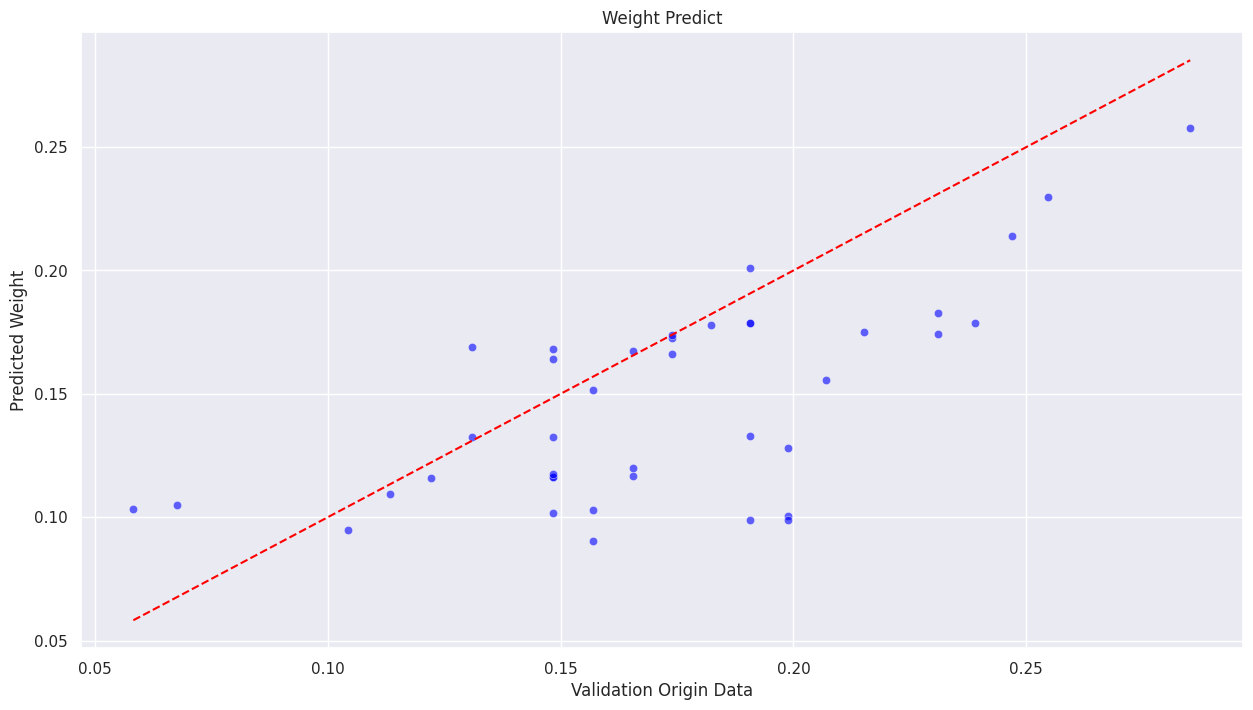

Human Search Test MAE :  0.0287
Human Search Test MAPE :  22.8574%


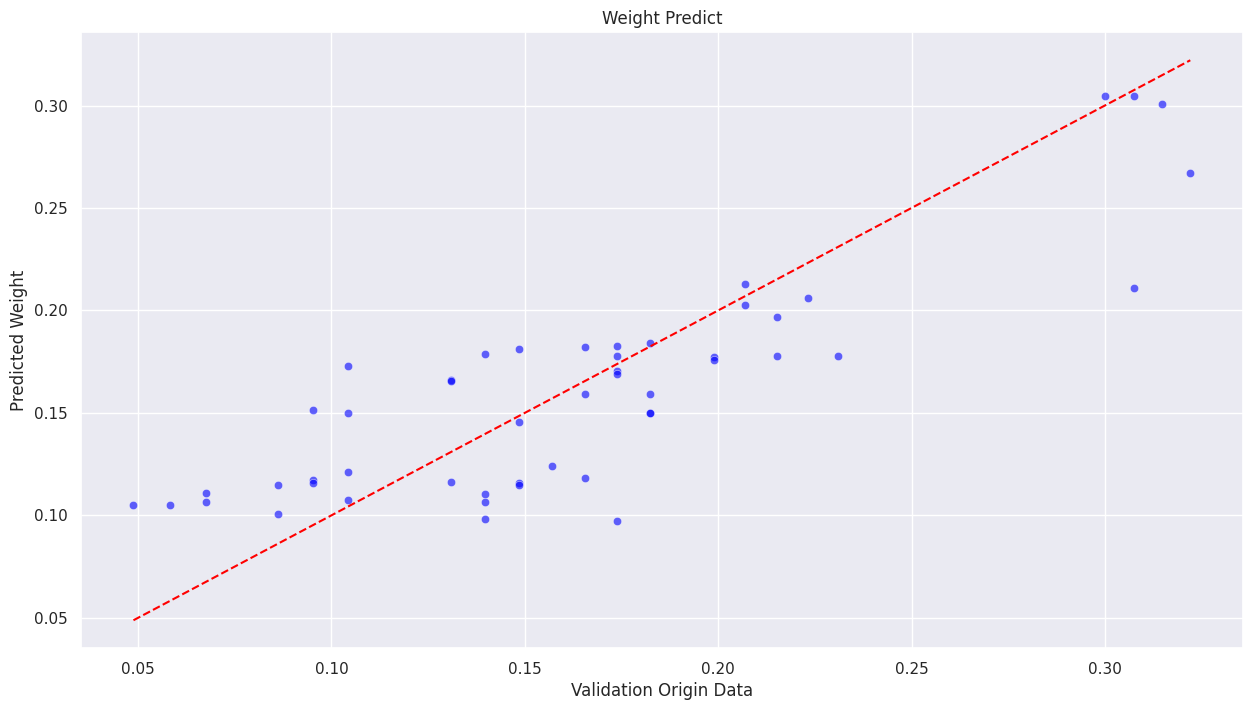

In [358]:
# modeling

params = {
    'random_state' : 2024,
    'min_samples_leaf' : 3, # leaf노드의 최소 샘플 수
    'max_depth' : 5, # 트리의 최대 깊이
    'max_features' : 0.5, # ffeature sampling 비율
    'criterion' : 'absolute_error', # 분할 척도
    'n_estimators' : 100, # 앙상블 트리 수
    'n_jobs' : -1, # 계산 cpu 수
}

# params = {
#     'random_state' : 2024,
#     'min_samples_leaf' : 5, # leaf노드의 최소 샘플 수
#     'max_depth' : 10, # 트리의 최대 깊이
#     'max_features' : 0.8, # ffeature sampling 비율
#     'criterion' : 'absolute_error', # 분할 척도
#     'n_estimators' : 50, # 앙상블 트리 수
#     'n_jobs' : -1, # 계산 cpu 수
# }

model = RandomForestRegressor(**params)
model.fit(x_train, y_train)
pred_val = model.predict(x_val)
# 앙상블을 위한 모델 저장
models.append(model)

val_mae = mean_absolute_error(y_val, pred_val)
print(f'Human Search Validation MAE : {val_mae : .4f}')
val_mape = mean_absolute_percentage_error(y_val, pred_val)
print(f'Human Search Validation MAPE : {val_mape * 100 : .4f}%')
origin_test_scatter(y_val, pred_val)

# Test
pred = model.predict(test)
test_mae = mean_absolute_error(answer, pred)
print(f'Human Search Test MAE : {test_mae : .4f}')
test_mape = mean_absolute_percentage_error(answer, pred)
print(f'Human Search Test MAPE : {test_mape * 100 : .4f}%')
origin_test_scatter(answer, pred)

## Human Search Modeling (ER)

Human Search Validation MAE :  0.0309
Human Search Validation MAPE :  18.7545%


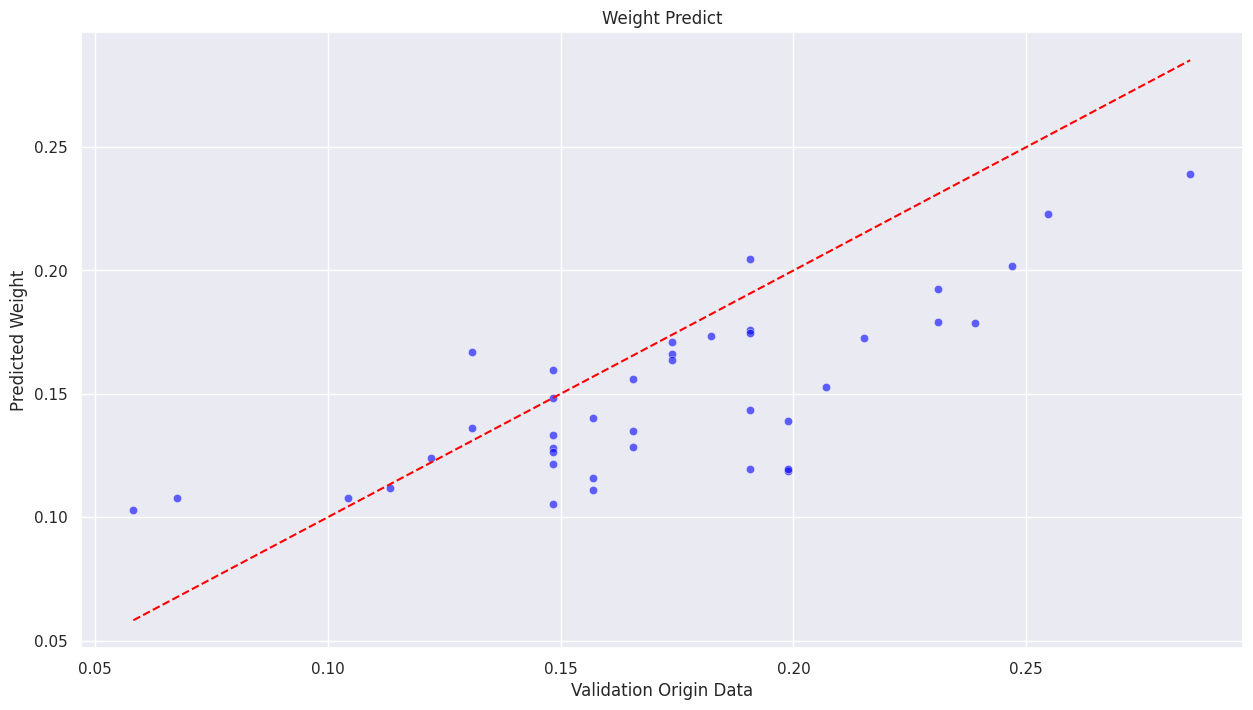

Human Search Test MAE :  0.0286
Human Search Test MAPE :  22.7730%


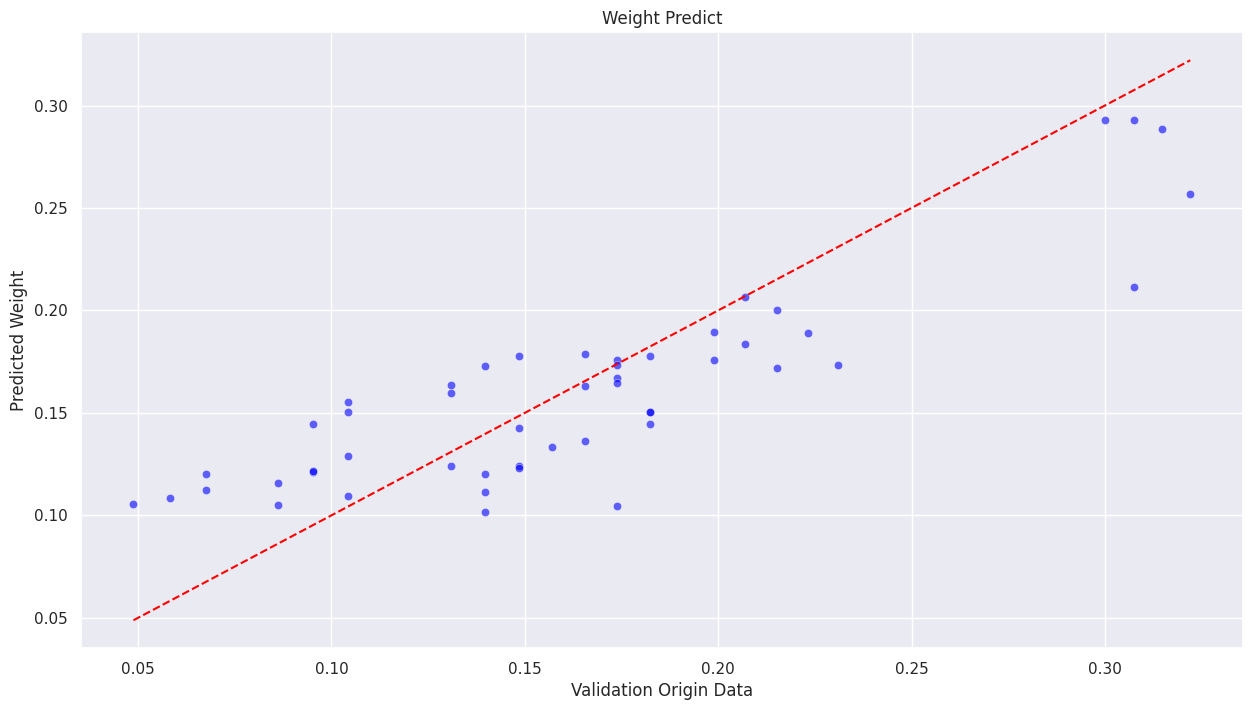

In [359]:
# modeling
#
params = {
    'random_state' : 2024,
    'min_samples_leaf' : 3, # leaf노드의 최소 샘플 수
    'max_depth' : 5, # 트리의 최대 깊이
    'max_features' : 0.5, # feature sampling 비율
    'criterion' : 'absolute_error', # 분할 척도
    'n_estimators' : 100, # 앙상블 트리 수
    'n_jobs' : -1, # 계산 cpu 수
}

model = ExtraTreesRegressor(**params)
model.fit(x_train, y_train)
pred_val = model.predict(x_val)
# 앙상블을 위한 모델 저장
models.append(model)

val_mae = mean_absolute_error(y_val, pred_val)
print(f'Human Search Validation MAE : {val_mae : .4f}')
val_mape = mean_absolute_percentage_error(y_val, pred_val)
print(f'Human Search Validation MAPE : {val_mape * 100 : .4f}%')
origin_test_scatter(y_val, pred_val)

# Test
pred = model.predict(test)
test_mae = mean_absolute_error(answer, pred)
print(f'Human Search Test MAE : {test_mae : .4f}')
test_mape = mean_absolute_percentage_error(answer, pred)
print(f'Human Search Test MAPE : {test_mape * 100 : .4f}%')
origin_test_scatter(answer, pred)

## Human Search Modeling (XGBoost)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:40:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_child_samples" } are not used.

  warnings.warn(smsg, UserWarning)


Human Search Validation MAE :  0.0333
Human Search Validation MAPE :  20.2380%


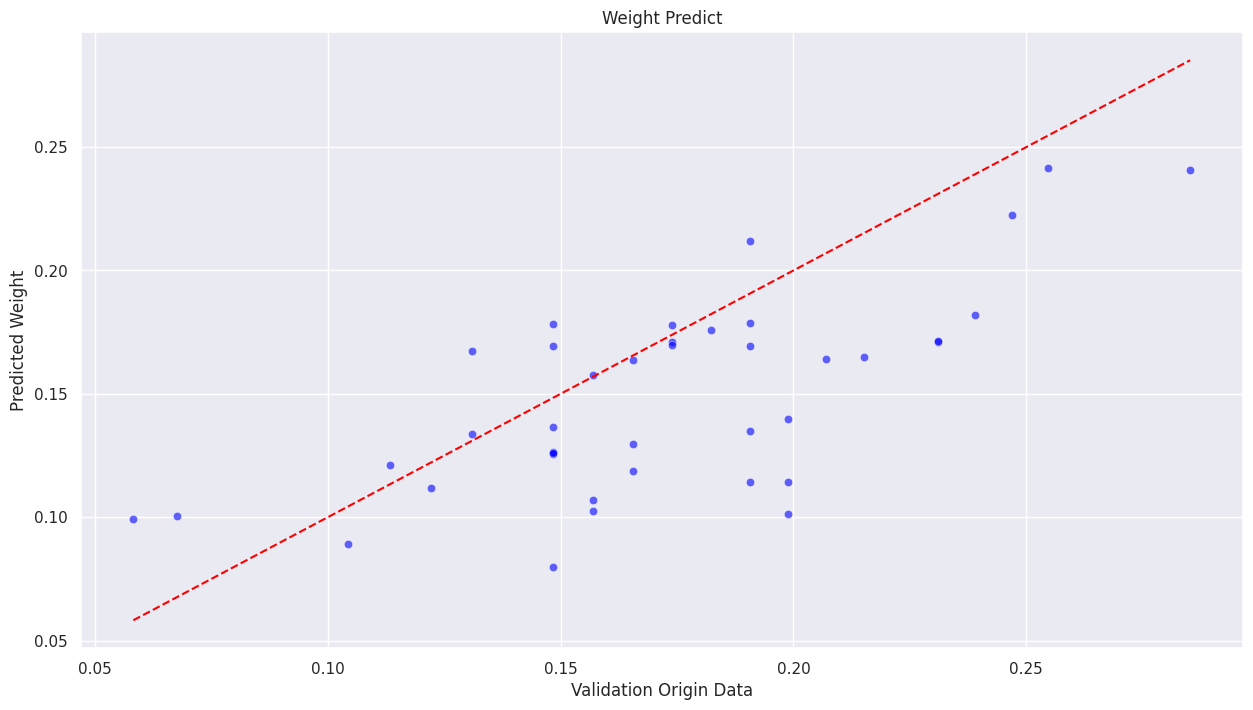

Human Search Test MAE :  0.0322
Human Search Test MAPE :  24.7107%


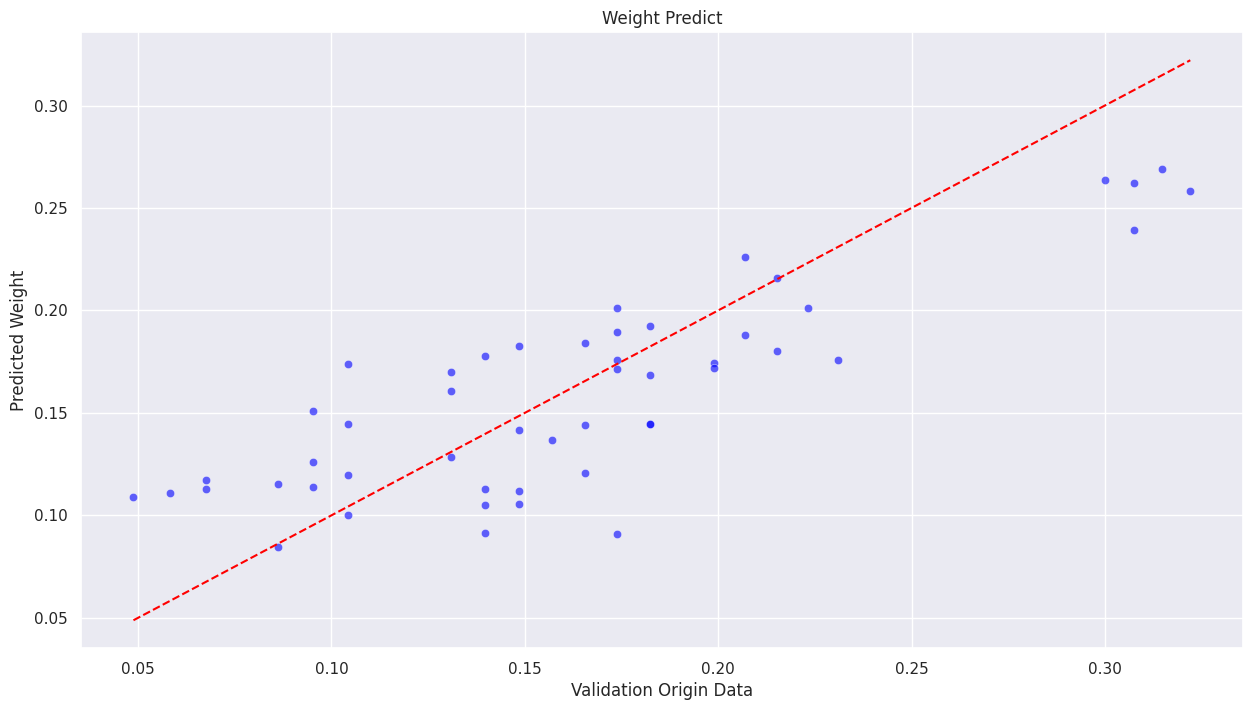

In [304]:
# XGBoost 모델 생성

params = {
    'random_state' : 2024,
    'n_estimators': 50,              # 트리 개수
    'learning_rate': 0.05,            # 학습률
    'max_depth':25,                   # 트리의 최대 깊이
    'min_child_samples' : 5,
    'subsample': 0.5,                 # 데이터 샘플링 비율
    'colsample_bytree': 0.5,          # 트리마다 특징 샘플링 비율
    'n_jobs': -1                      # 모든 CPU 코어 사용

}

# 잔차 계산을 위한 모델 생성
model = xgb.XGBRegressor(**params)
model.fit(x_train, y_train)
# 예측
y_train_pred = model.predict(x_train)
# 잔차가 클수록 더 큰 가중치 부여
residuals = np.abs(y_train - y_train_pred)
sample_weights = residuals / np.max(residuals)

# # KMeans 클러스터링 (5개 군집으로 나누기)
# kmeans = KMeans(n_clusters=5, random_state=42)
# kmeans.fit(x_train)

# # 군집 레이블을 기반으로 가중치 설정
# cluster_labels = kmeans.labels_
# sample_weights = cluster_labels + 1  # 각 군집에 다른 가중치 부여

# 본 모델 생성
model = xgb.XGBRegressor(**params)
model.fit(x_train, y_train, sample_weight = sample_weights)
pred_val = model.predict(x_val)
# 앙상블을 위한 모델 저장
models.append(model)

val_mae = mean_absolute_error(y_val, pred_val)
print(f'Human Search Validation MAE : {val_mae : .4f}')
val_mape = mean_absolute_percentage_error(y_val, pred_val)
print(f'Human Search Validation MAPE : {val_mape * 100 : .4f}%')
origin_test_scatter(y_val, pred_val)

# Test
pred = model.predict(test)
test_mae = mean_absolute_error(answer, pred)
print(f'Human Search Test MAE : {test_mae : .4f}')
test_mape = mean_absolute_percentage_error(answer, pred)
print(f'Human Search Test MAPE : {test_mape * 100 : .4f}%')
origin_test_scatter(answer, pred)

## Human Search Modeling (LGBM)

Human Search Validation MAE :  0.0332
Human Search Validation MAPE :  20.5375%


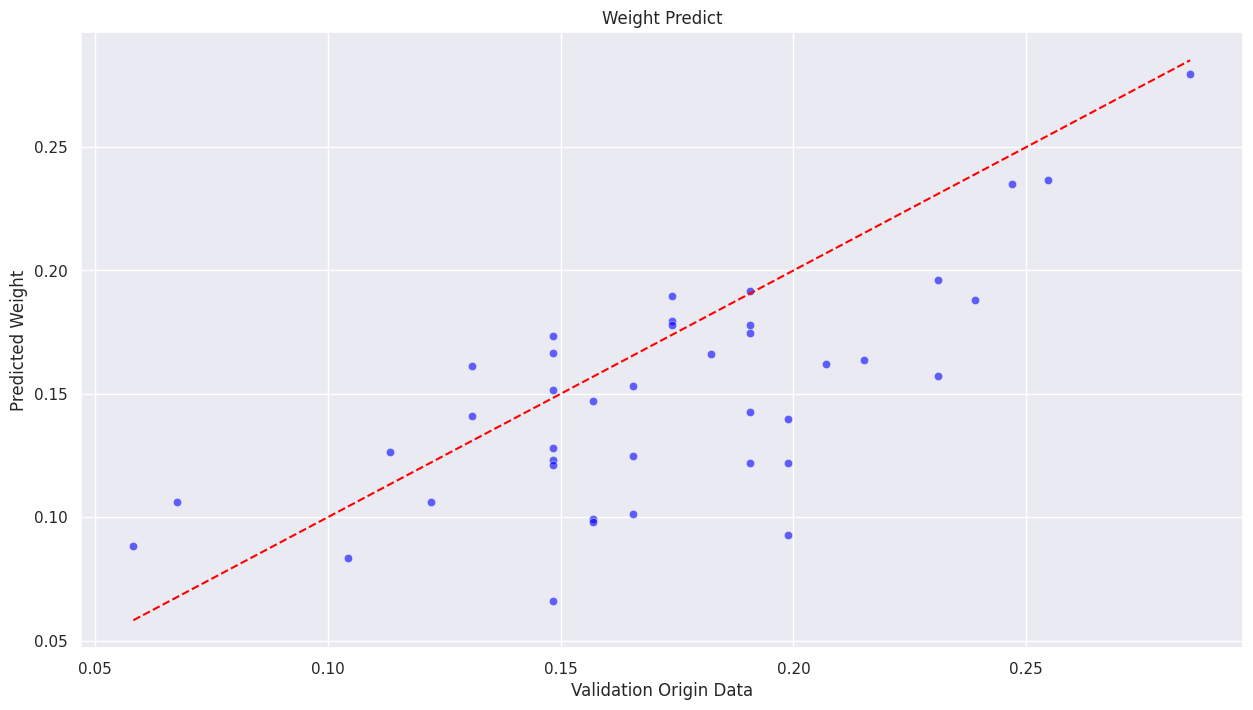

Human Search Test MAE :  0.0323
Human Search Test MAPE :  26.0852%


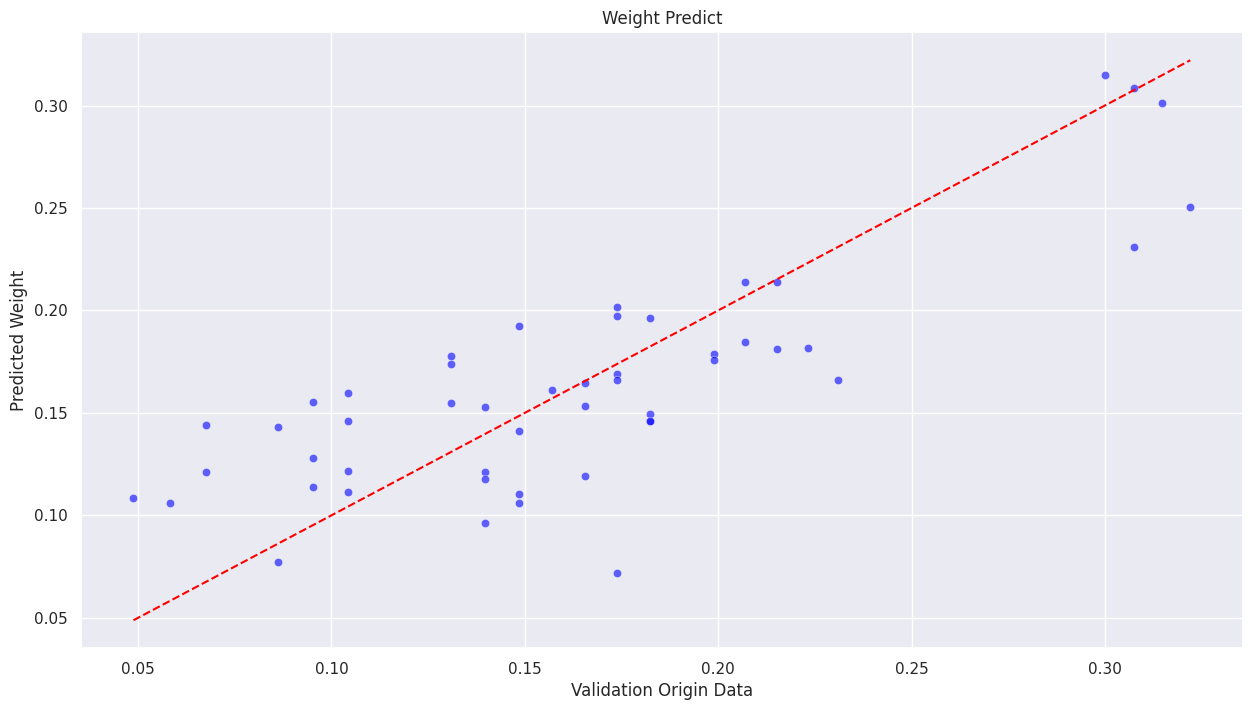

In [325]:
# LGBM 모델 생성

params = {
    'random_state' : 2024,
    'n_estimators': 100,              # 트리 개수
    'learning_rate': 0.05,            # 학습률
    'max_depth':25,                   # 트리의 최대 깊이
    'min_child_samples' : 5,
    'subsample': 0.8,                 # 데이터 샘플링 비율
    'colsample_bytree': 0.5,          # 트리마다 특징 샘플링 비율
    'n_jobs': -1                      # 모든 CPU 코어 사용

}

# params = {
#     'random_state' : 2024,
#     'objective': 'regression',
#     'metric': 'mae',
#     'learning_rate': 0.05,  # 학습률 감소
#     'max_depth': 6,  # 트리의 최대 깊이 제한
#     'min_data_in_leaf': 20,  # 리프 노드의 최소 데이터 수 증가
#     'min_gain_to_split': 0.1,  # 분할을 위한 최소 이득 증가
#     'num_leaves': 31,  # 하나의 트리가 가질 수 있는 최대 리프 개수
#     'feature_fraction': 0.8,  # 특성 선택 비율
#     'bagging_fraction': 0.8,  # 데이터 샘플링 비율
#     'bagging_freq': 5,  # 배깅 빈도수 설정
#     'verbose': -1
# }

# 잔차 계산을 위한 모델 생성
model = lgb.LGBMRegressor(**params)
model.fit(x_train, y_train)
# 예측
y_train_pred = model.predict(x_train)
# 잔차가 클수록 더 큰 가중치 부여
residuals = np.abs(y_train - y_train_pred)
sample_weights = residuals / np.max(residuals)

# # KMeans 클러스터링 (5개 군집으로 나누기)
# kmeans = KMeans(n_clusters=5, random_state=42)
# kmeans.fit(x_train)

# # 군집 레이블을 기반으로 가중치 설정
# cluster_labels = kmeans.labels_
# sample_weights = cluster_labels + 1  # 각 군집에 다른 가중치 부여

# 본 모델 생성
model = lgb.LGBMRegressor(**params)
model.fit(x_train, y_train, sample_weight = sample_weights)
pred_val = model.predict(x_val)
# 앙상블을 위한 모델 저장
models.append(model)

val_mae = mean_absolute_error(y_val, pred_val)
print(f'Human Search Validation MAE : {val_mae : .4f}')
val_mape = mean_absolute_percentage_error(y_val, pred_val)
print(f'Human Search Validation MAPE : {val_mape * 100 : .4f}%')
origin_test_scatter(y_val, pred_val)

# Test
pred = model.predict(test)
test_mae = mean_absolute_error(answer, pred)
print(f'Human Search Test MAE : {test_mae : .4f}')
test_mape = mean_absolute_percentage_error(answer, pred)
print(f'Human Search Test MAPE : {test_mape * 100 : .4f}%')
origin_test_scatter(answer, pred)

## Human Search Test Data Ensemble

[RandomForestRegressor(criterion='absolute_error', max_depth=5, max_features=0.5,
                      min_samples_leaf=3, n_jobs=-1, random_state=2024), ExtraTreesRegressor(criterion='absolute_error', max_depth=5, max_features=0.5,
                    min_samples_leaf=3, n_jobs=-1, random_state=2024)]
RandomForestRegressor(criterion='absolute_error', max_depth=5, max_features=0.5,
                      min_samples_leaf=3, n_jobs=-1, random_state=2024)
ExtraTreesRegressor(criterion='absolute_error', max_depth=5, max_features=0.5,
                    min_samples_leaf=3, n_jobs=-1, random_state=2024)
----- test preds check -----
predict :  [0.18097418 0.16604779 0.11091522 0.10061308 0.17773429]
predict :  [0.17773811 0.1635458  0.11243344 0.10514862 0.17352516]
enesmble predict :  [0.17935614 0.1647968  0.11167433 0.10288085 0.17562972]
----------------------------
Human Search Ensemble MAE :  0.0285
Human Search Ensemble MAPE :  22.7537%


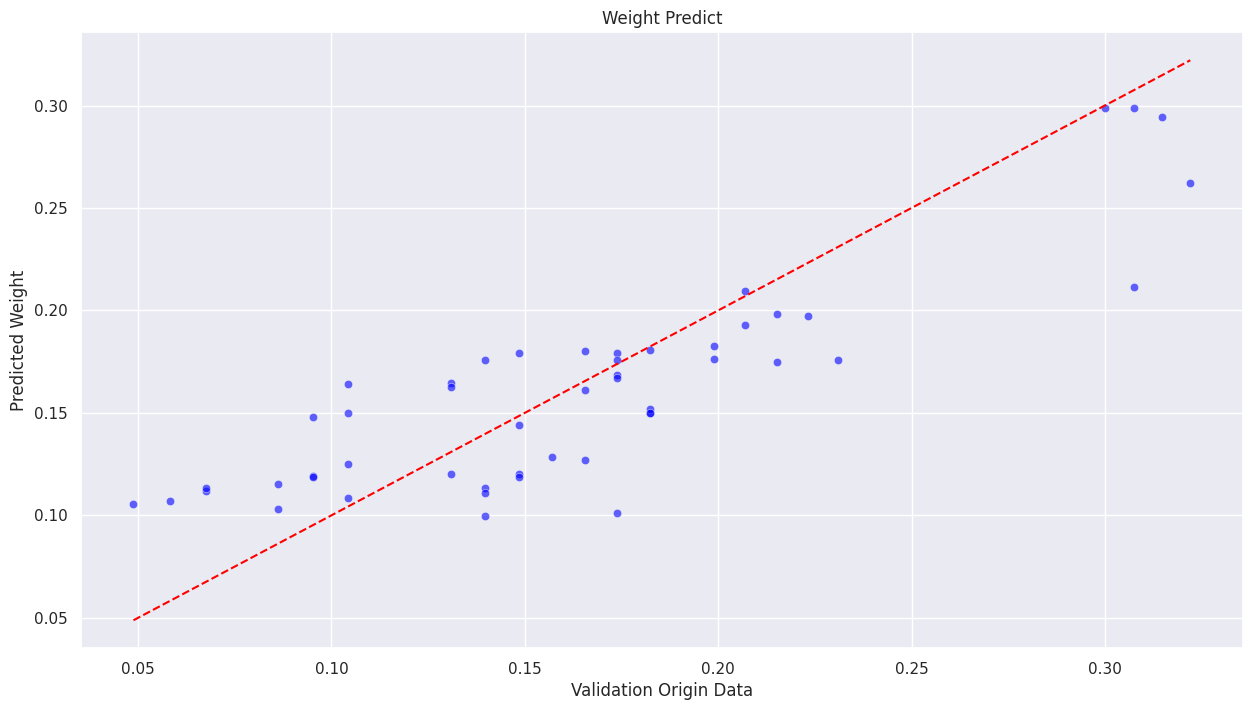

In [360]:
preds = []
print(models)
for model in models:
    print(model)
    pred = model.predict(test)
    preds.append(pred)

# pred = np.mean([preds[0], preds[1], preds[2], preds[3]], axis = 0)
pred = np.mean(preds, axis = 0)
print('----- test preds check -----')
for p in preds:
    print('predict : ', p[:5])
print('enesmble predict : ', pred[:5])
print('----------------------------')
test_mae = mean_absolute_error(answer, pred)
print(f'Human Search Ensemble MAE : {test_mae : .4f}')
test_mape = mean_absolute_percentage_error(answer, pred)
print(f'Human Search Ensemble MAPE : {test_mape * 100 : .4f}%')
origin_test_scatter(answer, pred)

In [362]:
from sklearn.ensemble import StackingRegressor

params = {
    'random_state' : 2024,
    'min_samples_leaf' : 3, # leaf노드의 최소 샘플 수
    'max_depth' : 5, # 트리의 최대 깊이
    'max_features' : 0.5, # feature sampling 비율
    'criterion' : 'absolute_error', # 분할 척도
    'n_estimators' : 100, # 앙상블 트리 수
    'n_jobs' : -1, # 계산 cpu 수
}

boosting_params = {
    'random_state' : 2024,
    'n_estimators': 100,              # 트리 개수
    'learning_rate': 0.05,            # 학습률
    'max_depth':25,                   # 트리의 최대 깊이
    # 'min_child_samples' : 5,
    'subsample': 0.5,                 # 데이터 샘플링 비율
    'colsample_bytree': 0.5,          # 트리마다 특징 샘플링 비율
    'n_jobs': -1                      # 모든 CPU 코어 사용

}

base_learners = [
    ('rf', RandomForestRegressor(**params)),
    ('et', ExtraTreesRegressor(**params)),
    # ('xgb', xgb.XGBRegressor(**boosting_params)),
    # ('lgbm', lgb.LGBMRegressor(**boosting_params))
]

# meta_model = RandomForestRegressor(**params)
meta_model = ExtraTreesRegressor(**params)
# meta_model = lgb.LGBMRegressor(**boosting_params)
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=meta_model)

# 모델 학습
stacking_model.fit(x_train, y_train)

# 예측 및 평가
pred = stacking_model.predict(test)
print('----- test preds check -----')
print('Test mae : ',mean_absolute_error(answer, pred))
print('Test mape : ',mean_absolute_percentage_error(answer, pred)*100)

----- test preds check -----
Test mae :  0.032513167684086665
Test mape :  25.099754881353974


## Pycaret

In [392]:
##### get data
data_for_model = data_filtered

##### train, test split from "total data"
train, test = train_test_split(data_for_model, test_size = 0.2, random_state = 2024)
print('train-test shape : ', train.shape, test.shape)
cols = train.columns

##### get targets from train, test
target = train.pop('weight')
answer = test.pop('weight')
x_cols = train.columns

##### 로그변환
target = np.log1p(target)
answer = np.log1p(answer)

#### SMOTER
train = pd.DataFrame(np.column_stack((target, train)), columns=cols)
train, target = smoter(train, N=5, k_neighbors=5)

##### Data scaling
scaler = StandardScaler()
train = scaler.fit_transform(train) # numpy array
test = scaler.transform(test)

train = pd.concat([pd.DataFrame(train, columns=x_cols).reset_index(drop=True), pd.DataFrame(target, columns = ['weight']).reset_index(drop=True)], axis=1)
test = pd.DataFrame(test, columns=x_cols)

print('After Smote train-test shape : ', train.shape, test.shape, answer.shape)
display(train.head(5))
display(test.head(5))

train-test shape :  (215, 9) (54, 9)
After Smote train-test shape :  (1075, 9) (54, 8) (54,)


,seed_long,seed_short,leaf_1,leaf_2,leaf_length_sum,leaf_area,leaf_div_1,leaf_div_2,weight
0,0.193973,0.535756,-1.400145,-0.515011,-1.016076,-0.984144,-1.394662,1.491478,0.196568
1,0.482492,0.659352,-1.400145,-0.569270,-1.044068,-1.006851,-1.309534,1.369182,0.210503
2,0.929566,1.444408,-1.309516,-0.681360,-1.053324,-1.016236,-0.974887,0.919144,0.269330
3,0.183240,-0.178239,-1.199875,-0.656561,-0.981771,-0.960461,-0.832577,0.755619,0.185180
4,0.345162,0.788126,-1.215761,-0.842605,-1.086264,-1.050623,-0.493549,0.398137,0.215111


,seed_long,seed_short,leaf_1,leaf_2,leaf_length_sum,leaf_area,leaf_div_1,leaf_div_2
0,0.373994,-0.499338,-0.206819,-0.301136,-0.266196,-0.351135,0.102500,-0.261746
1,-0.128195,0.718575,0.068564,0.271018,0.176563,0.104951,-0.449557,0.298557
2,0.671465,1.467658,0.435741,1.224607,0.865300,0.884098,-1.226528,1.252476
3,-1.002445,-0.308272,0.711124,0.747812,0.766909,0.746322,-0.315725,0.154889
4,-0.169426,-0.116418,-0.023231,-1.159366,-0.610565,-0.754961,2.424648,-1.940468


In [393]:
from pycaret.regression import *
s = setup(train, target = 'weight', session_id = 2024, fold=5) # init training environment, session_id -> random seed
best = compare_models(sort='MAPE', n_select=7) # RANSAC 0.1 threshold, n_select=5 -> Mape 11%

,Description,Value
0,Session id,2024
1,Target,weight
2,Target type,Regression
3,Original data shape,"(1075, 9)"
4,Transformed data shape,"(1075, 9)"
5,Transformed train set shape,"(752, 9)"
6,Transformed test set shape,"(323, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0079,0.0001,0.0111,0.9609,0.0093,0.0428,0.2480
xgboost,Extreme Gradient Boosting,0.0095,0.0002,0.0131,0.9463,0.0108,0.0511,0.1920
rf,Random Forest Regressor,0.0099,0.0002,0.0132,0.9448,0.0110,0.0528,0.4620
lightgbm,Light Gradient Boosting Machine,0.0100,0.0002,0.0136,0.9418,0.0112,0.0536,1.0600
gbr,Gradient Boosting Regressor,0.0111,0.0002,0.0143,0.9355,0.0119,0.0602,0.2260
knn,K Neighbors Regressor,0.0122,0.0003,0.0161,0.9172,0.0134,0.0647,0.0320
dt,Decision Tree Regressor,0.0127,0.0004,0.0192,0.8824,0.0160,0.0692,0.0300
ada,AdaBoost Regressor,0.0145,0.0003,0.0177,0.9013,0.0147,0.0801,0.1440
huber,Huber Regressor,0.0164,0.0004,0.0209,0.8637,0.0173,0.0893,0.0500
lr,Linear Regression,0.0165,0.0004,0.0206,0.8662,0.0172,0.0896,0.0500


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

In [394]:
# # 트리 계열
# tree_models = ['et', 'rf']
# tree_params = {
#     'max_depth': 5,  # 트리 깊이 제한
#     'min_samples_leaf' : 10,  # 최소 분할 샘플 수
#     'max_features': 0.5,  # 특징 선택을 제약 (최대 특징 수)
#     'criterion' : 'absolute_error',
#     'n_estimators' : 100,
# }

# # 부스팅 계열
# boosting_models = ['lightgbm', 'xgboost']
# boosting_params = {
#     'learning_rate': 0.01,  # 학습률 설정
#     'n_estimators': 100,  # 트리 개수 설정
#     'max_depth': 10,  # 트리 깊이 제한
#     'min_child_weight': 1,  # 자식 노드 최소 가중치
#     'subsample': 0.8,  # 데이터 샘플링 비율
#     'colsample_bytree': 0.8,  # 트리마다 특징 샘플링 비율
# }

# # 트리 계열 모델 생성 (과적합 방지 파라미터 적용)
# tree_models_created = [
#     create_model(model, **tree_params) for model in tree_models
# ]

# # 부스팅 계열 모델 생성 (과적합 방지 파라미터 적용)
# boosting_models_created = [
#     create_model(model, **boosting_params) for model in boosting_models
# ]

# # 모든 모델을 합침
# all_models = tree_models_created + boosting_models_created

# 모델 튜닝
tuned_models = [tune_model(model, n_iter=10, optimize='mape') for model in best]
print(tuned_models)

# 모델 블렌딩
blender = blend_models(tuned_models)
# stacker = stack_models(all_models, meta_model=RandomForestRegressor(random_state=2024, n_jobs=-1))
# print(stacker.estimators)

# 예측
prediction = predict_model(blender, data=test)
# prediction = predict_model(stacker, data=test)

# print(prediction)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0186,0.0005,0.0232,0.8307,0.0192,0.1069
1,0.0177,0.0005,0.0227,0.8260,0.0189,0.0994
2,0.0193,0.0006,0.0240,0.8345,0.0198,0.1022
3,0.0192,0.0006,0.0240,0.8423,0.0197,0.1027
4,0.0189,0.0006,0.0240,0.7935,0.0198,0.0980
Mean,0.0187,0.0006,0.0236,0.8254,0.0195,0.1018
Std,0.0006,0.0000,0.0005,0.0168,0.0004,0.0031


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0097,0.0002,0.0133,0.9444,0.0110,0.0545
1,0.0109,0.0002,0.0138,0.9357,0.0115,0.0600
2,0.0101,0.0002,0.0133,0.9494,0.0110,0.0540
3,0.0092,0.0002,0.0125,0.9575,0.0104,0.0498
4,0.0093,0.0002,0.0125,0.9440,0.0103,0.0484
Mean,0.0098,0.0002,0.0131,0.9462,0.0108,0.0533
Std,0.0006,0.0000,0.0005,0.0072,0.0004,0.0041


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0132,0.0003,0.0171,0.9079,0.0142,0.0744
1,0.0135,0.0003,0.0174,0.8977,0.0145,0.0750
2,0.0137,0.0003,0.0176,0.9113,0.0145,0.0721
3,0.0132,0.0003,0.0171,0.9197,0.0140,0.0695
4,0.0137,0.0003,0.0180,0.8834,0.0148,0.0697
Mean,0.0134,0.0003,0.0175,0.9040,0.0144,0.0721
Std,0.0002,0.0000,0.0003,0.0125,0.0003,0.0023


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0293,0.0014,0.0379,0.5469,0.0316,0.1776
1,0.0277,0.0013,0.0365,0.5511,0.0302,0.1593
2,0.0324,0.0018,0.0429,0.4713,0.0351,0.1710
3,0.0337,0.0019,0.0436,0.4813,0.0358,0.1859
4,0.0268,0.0012,0.0345,0.5728,0.0285,0.1462
Mean,0.0300,0.0015,0.0391,0.5247,0.0322,0.1680
Std,0.0027,0.0003,0.0036,0.0406,0.0028,0.0140


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0115,0.0002,0.0149,0.9303,0.0124,0.0656
1,0.0127,0.0002,0.0156,0.9186,0.0130,0.0711
2,0.0119,0.0002,0.0154,0.9322,0.0128,0.0639
3,0.0114,0.0002,0.0144,0.9431,0.0120,0.0626
4,0.0113,0.0002,0.0139,0.9307,0.0115,0.0595
Mean,0.0118,0.0002,0.0148,0.9310,0.0123,0.0646
Std,0.0005,0.0000,0.0006,0.0078,0.0005,0.0039


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0108,0.0002,0.0144,0.9349,0.0118,0.0593
1,0.0123,0.0003,0.0171,0.9012,0.0142,0.0674
2,0.0117,0.0002,0.0155,0.9307,0.0129,0.0615
3,0.0119,0.0003,0.0158,0.9315,0.0130,0.0638
4,0.0126,0.0003,0.0166,0.9012,0.0136,0.0632
Mean,0.0119,0.0003,0.0159,0.9199,0.0131,0.0631
Std,0.0006,0.0000,0.0010,0.0154,0.0008,0.0027


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0129,0.0003,0.0168,0.9109,0.0141,0.0744
1,0.0137,0.0003,0.0178,0.8928,0.0147,0.0744
2,0.0131,0.0003,0.0177,0.9100,0.0146,0.0687
3,0.0122,0.0003,0.0167,0.9239,0.0139,0.0671
4,0.0148,0.0004,0.0202,0.8545,0.0166,0.0764
Mean,0.0134,0.0003,0.0178,0.8984,0.0148,0.0722
Std,0.0009,0.0000,0.0012,0.0241,0.0009,0.0036


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
[ExtraTreesRegressor(n_jobs=-1, random_state=2024), XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=2024, ...), RandomForestRegressor(n_jobs=-1, random_state=20

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0086,0.0001,0.0119,0.9552,0.0099,0.0475
1,0.0104,0.0002,0.0132,0.9414,0.0110,0.0572
2,0.0092,0.0002,0.0126,0.9546,0.0105,0.0499
3,0.0095,0.0002,0.0128,0.9553,0.0106,0.0515
4,0.0095,0.0002,0.0124,0.9449,0.0102,0.0485
Mean,0.0094,0.0002,0.0126,0.9503,0.0104,0.0509
Std,0.0006,0.0000,0.0004,0.0059,0.0004,0.0034


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Pycaret Blender MAE :  0.0216
Pycaret Blender MAPE :  11.4935%


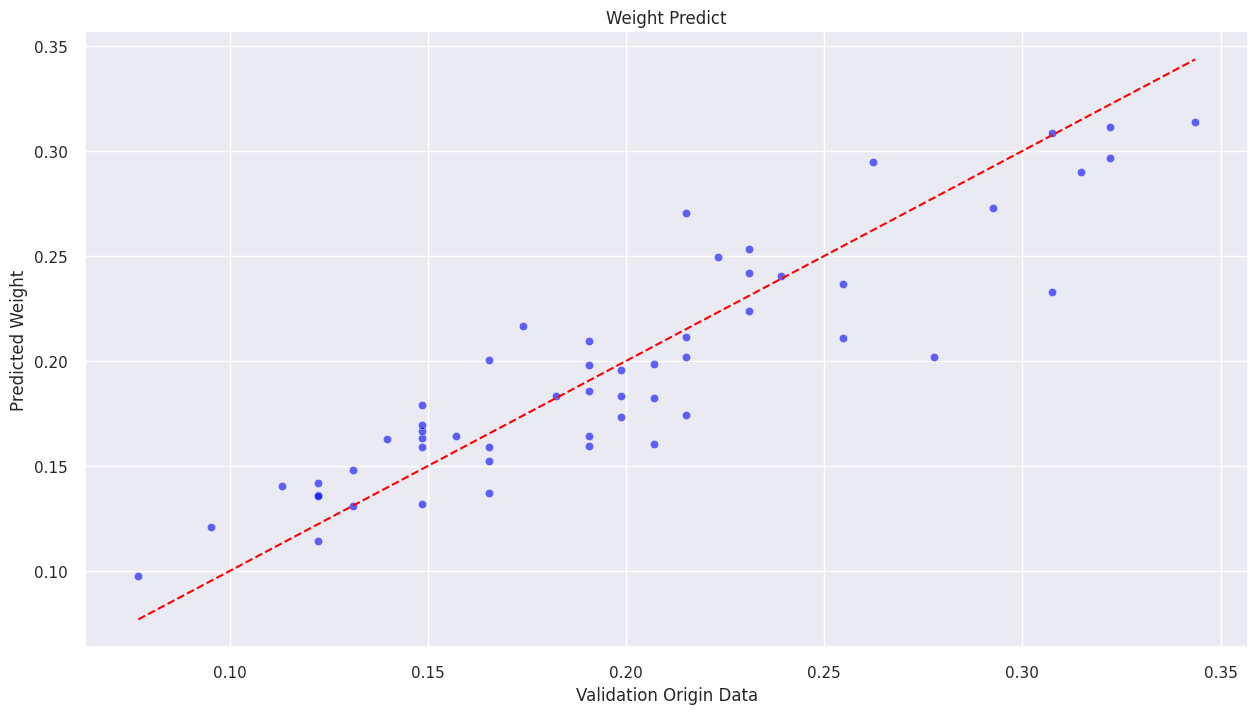

In [396]:
pred = prediction.prediction_label.values
test_mae = mean_absolute_error(answer, pred)
print(f'Pycaret Blender MAE : {test_mae : .4f}')
test_mape = mean_absolute_percentage_error(answer, pred)
print(f'Pycaret Blender MAPE : {test_mape * 100 : .4f}%')
origin_test_scatter(answer, pred)

## Grid Search Modeling

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=100;, score=-0.015 total time=   0.9s
[CV 2/5] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=100;, score=-0.015 total time=   1.3s
[CV 3/5] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=100;, score=-0.013 total time=   1.6s
[CV 4/5] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=100;, score=-0.013 total time=   1.5s
[CV 5/5] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=100;, score=-0.012 total time=   1.2s
[CV 1/5] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=150;, score=-0.015 total time=   1.3s
[CV 2/5] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_e

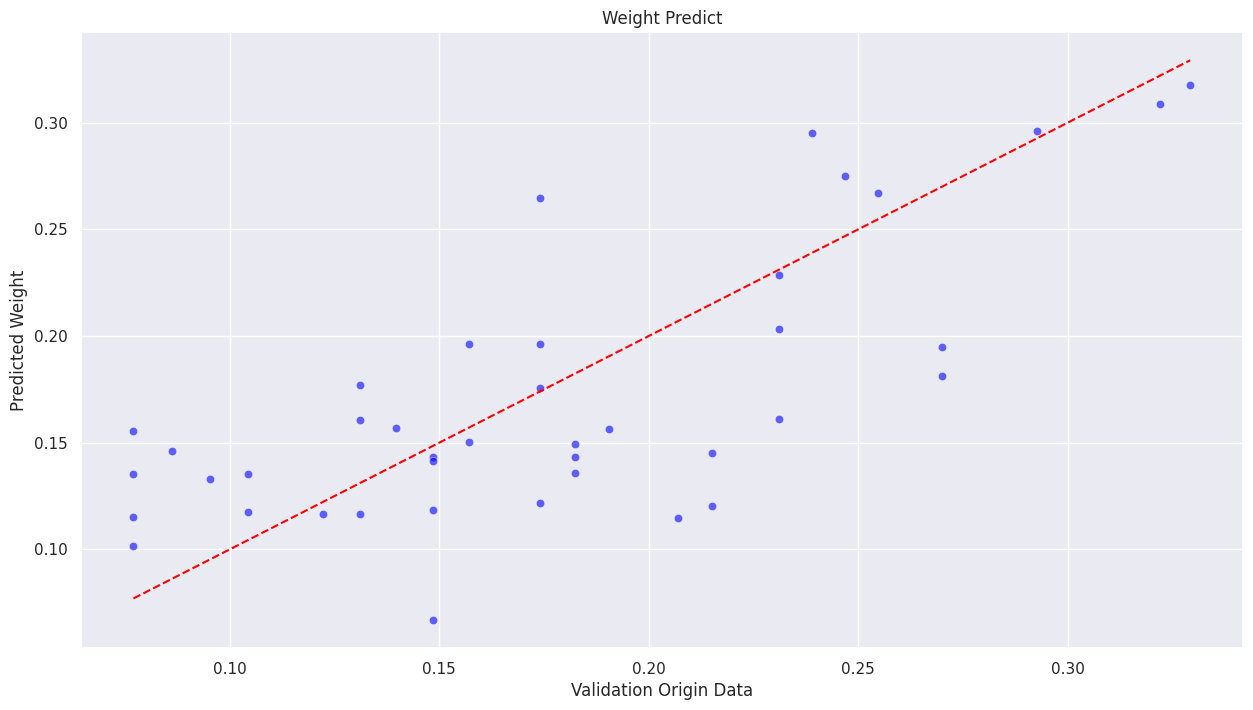

Grid Search CV Test MAE :  0.0477
Grid Search CV Test MAPE :  36.0757%


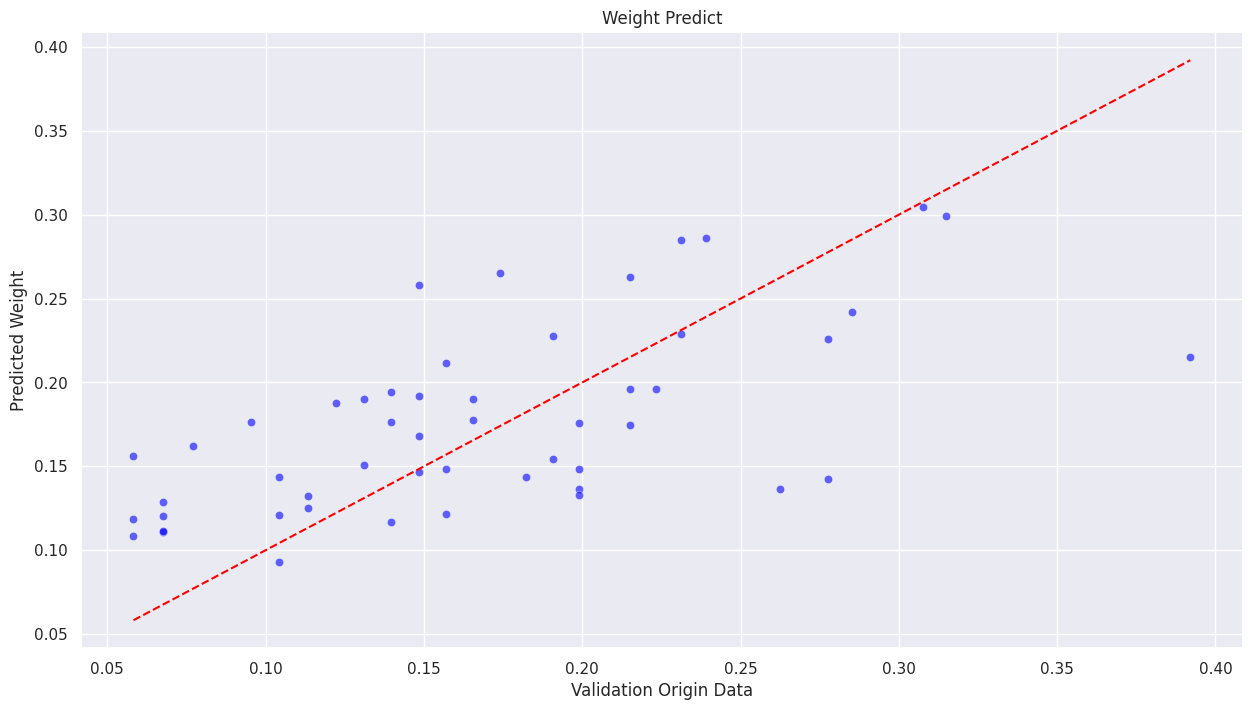

========== RF ==========
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=100;, score=-0.016 total time=   0.7s
[CV 2/5] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=100;, score=-0.016 total time=   0.5s
[CV 3/5] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=100;, score=-0.014 total time=   0.5s
[CV 4/5] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=100;, score=-0.014 total time=   0.5s
[CV 5/5] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=100;, score=-0.013 total time=   0.6s
[CV 1/5] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=150;, score=-0.016 total time=   0.8s
[CV 2/5] END criterion=absolute_error, max_depth=5, max_features=0.5

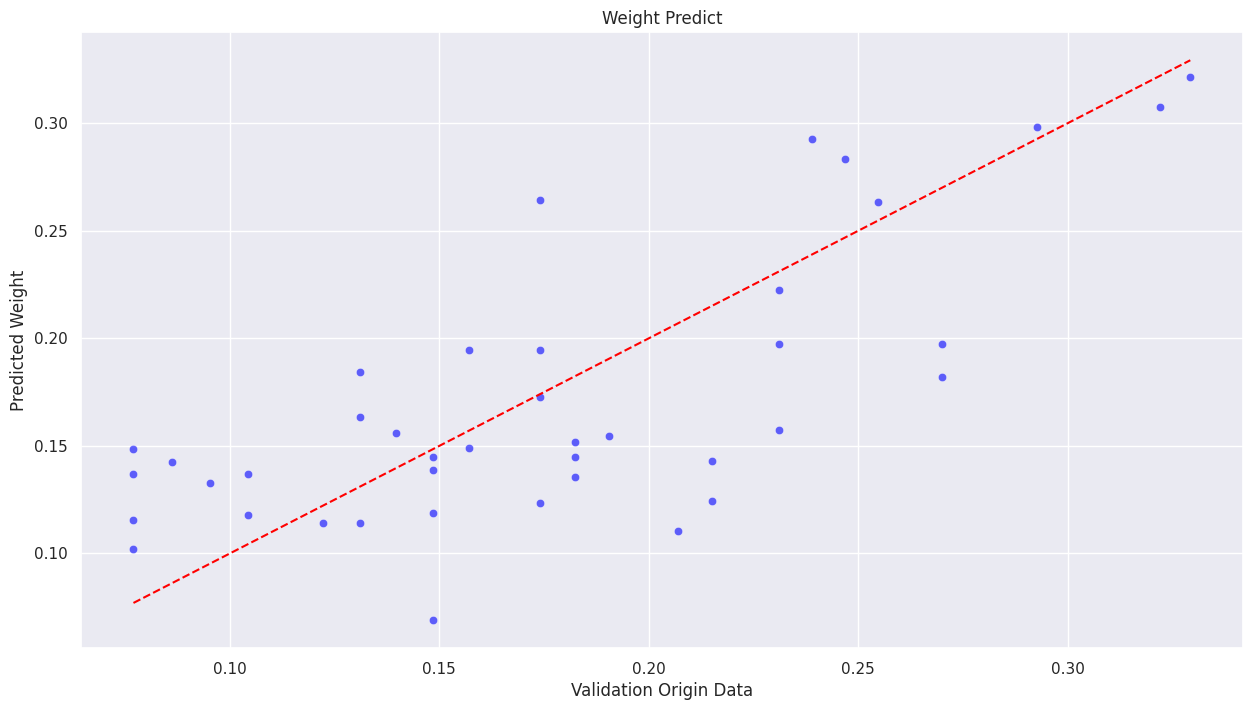

Grid Search CV Test MAE :  0.0471
Grid Search CV Test MAPE :  35.5847%


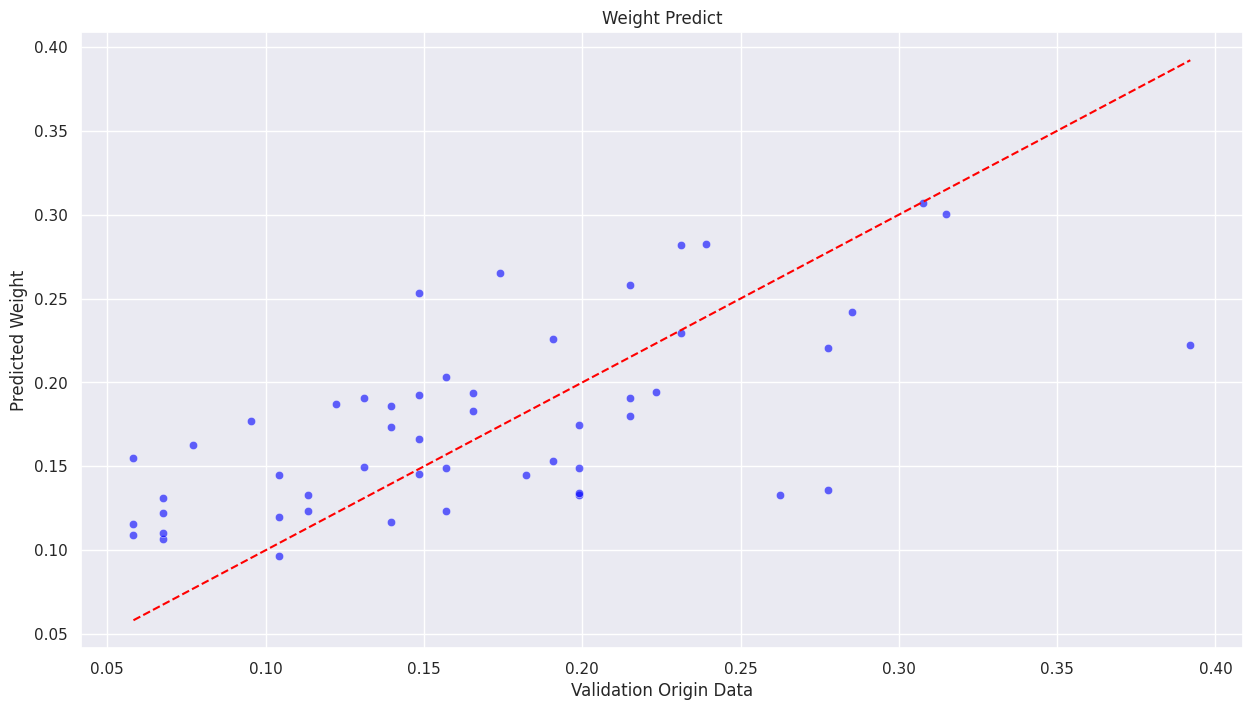

========== ER ==========
========== Ensemble ==========
----- test preds check -----
predict :  [0.28489818 0.12037153 0.11067014 0.19402325 0.15637235]
predict :  [0.28178006 0.12222085 0.10664757 0.1862429  0.15477033]
enesmble predict :  [0.28333912 0.12129619 0.10865885 0.19013308 0.15557134]
----------------------------
Grid Search CV Search Ensemble MAE :  0.0474
Grid Search CV Ensemble MAPE :  35.8302%


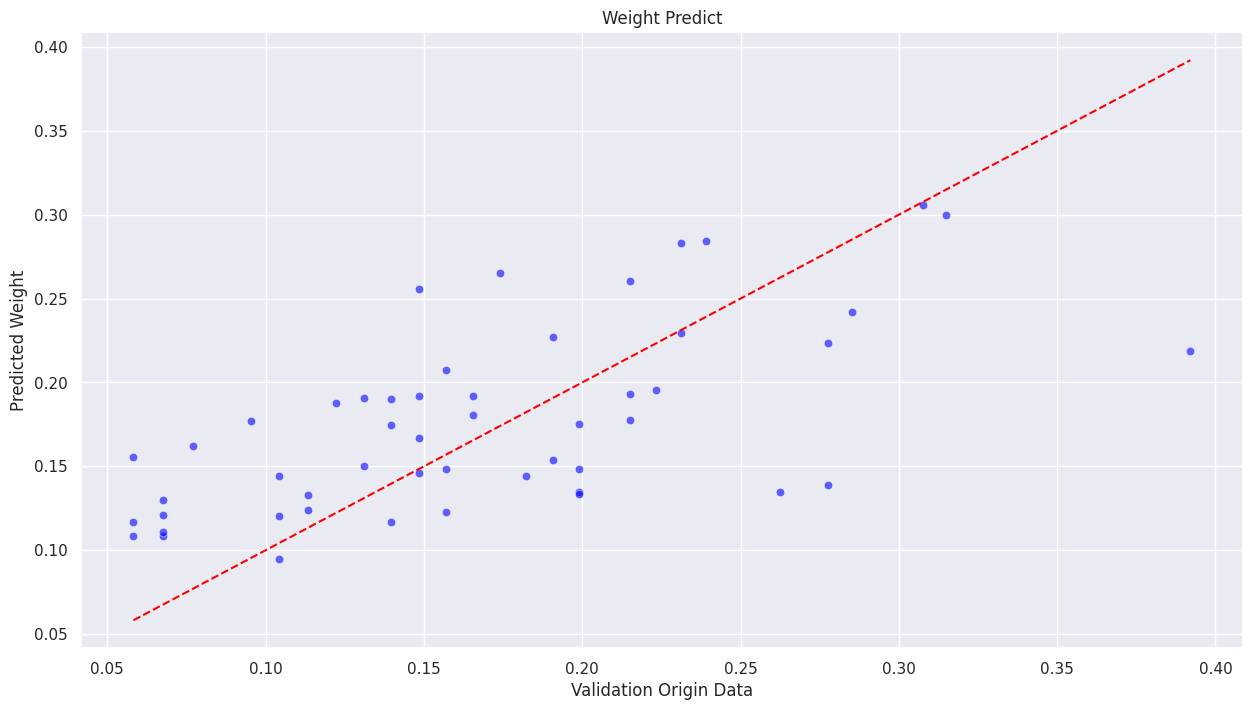

In [223]:
params = {
    # CART 관련
    'min_samples_leaf' : [3, 5],
    'max_depth' : [5, 8, 10],
    'max_features' : [0.5], # featrue sampling 비율
    'criterion' : ['absolute_error'], # 분할 척도
    # Tree Ensembole 관련
    'n_estimators':[100, 150, 200], # 앙상블 트리 수
}

#### ER mape 23.3123% best
# 'random_state' : 2024,
# 'min_samples_leaf' : 3, # leaf노드의 최소 샘플 수
# 'max_depth' : 5, # 트리의 최대 깊이
# 'max_features' : 0.5, # feature sampling 비율
# 'criterion' : 'absolute_error', # 분할 척도
# 'n_estimators' : 100, # 앙상블 트리 수
# 'n_jobs' : -1, # 계산 cpu 수

models = [RandomForestRegressor, ExtraTreesRegressor]
model_names = ['RF', 'ER']
preds = []
# model = RandomForestRegressor(random_state=2024, n_jobs=-1)
model = ExtraTreesRegressor(random_state=2024, n_jobs=-1)
for model, name in zip(models, model_names):
    created_model = model(random_state = 2024, n_jobs = -1)
    grid_cv = GridSearchCV(created_model , param_grid=params , cv=5, verbose=3, scoring='neg_mean_absolute_error') # cv:cv-fold 분발 수
    grid_cv.fit(x_train , y_train) # grid search start

    # GridSearchCV의 regit 파라미터가 기본 설정 되어있기 때문에, 최적 파라미터로 모든 데이터를 새로 학습한 모델이 gird_cv에 적용됨
    print(f'========== {name} ==========')
    print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
    print('최고 예측 정확도: {0:.4f}'.format(-grid_cv.best_score_))

    pred_val = grid_cv.predict(x_val)
    val_mae = mean_absolute_error(y_val, pred_val)
    print(f'Grid Search CV Validation MAE : {val_mae : .4f}')
    val_mape = mean_absolute_percentage_error(y_val, pred_val)
    print(f'Grid Search Validation MAPE : {val_mape * 100 : .4f}%')
    origin_test_scatter(y_val, pred_val)

    pred = grid_cv.predict(test)
    preds.append(pred)
    test_mae = mean_absolute_error(answer, pred)
    print(f'Grid Search CV Test MAE : {test_mae : .4f}')
    test_mape = mean_absolute_percentage_error(answer, pred)
    print(f'Grid Search CV Test MAPE : {test_mape * 100 : .4f}%')
    origin_test_scatter(answer, pred)
    print(f'========== {name} ==========')

print(f'========== Ensemble ==========')
pred = np.mean(preds, axis = 0)
print('----- test preds check -----')
for p in preds:
    print('predict : ', p[:5])
print('enesmble predict : ', pred[:5])
print('----------------------------')
test_mae = mean_absolute_error(answer, pred)
print(f'Grid Search CV Search Ensemble MAE : {test_mae : .4f}')
test_mape = mean_absolute_percentage_error(answer, pred)
print(f'Grid Search CV Ensemble MAPE : {test_mape * 100 : .4f}%')
origin_test_scatter(answer, pred)

## Human Searching after Grid Searh CV

Grid Search 결과

* 최적 하이퍼 파라미터:
 {'criterion': 'absolute_error', 'max_depth': 6, 'max_features': 0.8, 'min_samples_leaf': 8, 'n_estimators': 150}
* 최고 예측 정확도: 0.0569
* Grid Search CV Validation MAE :  0.0575
* Grid Search Validation MAPE :  31.3919%
* Grid Search CV MAE :  0.0540
* Grid Search CV MAPE :  26.6781%

In [ ]:
# modeling

params = {
    'random_state' : 2024,
    'criterion': 'absolute_error',
    'max_depth': 6,
    'max_features': 0.8,
    # 'min_samples_split': 20,
    'min_samples_leaf': 8,
    'n_estimators': 50,
    'n_jobs' : -1,
}

# {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 5, 'n_estimators': 100}

model = RandomForestRegressor(**params)
model.fit(x_train, y_train)
pred_val = model.predict(x_val)

val_mae = mean_absolute_error(y_val, pred_val)
print(f'Validation MAE : {val_mae : .4f}')
val_mape = mean_absolute_percentage_error(y_val, pred_val)
print(f'Validation MAPE : {val_mape * 100 : .4f}%')

pred = model.predict(test)
test_mae = mean_absolute_error(answer, pred)
print(f'Test MAE : {test_mae : .4f}')
test_mape = mean_absolute_percentage_error(answer, pred)
print(f'Test MAPE : {test_mape * 100 : .4f}%')
origin_test_scatter(answer, pred)

Validation MAE :  0.0418
Validation MAPE :  22.5238%
Test MAE :  0.0569
Test MAPE :  28.9585%


Validation MAE :  0.0418  
Validation MAPE :  22.5238%  
Test MAE :  0.0569  
Test MAPE :  28.9585%  